In [1]:
import time
from typing import Any, Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import shap
from sklearn.ensemble import (ExtraTreesRegressor, GradientBoostingRegressor,
                              RandomForestRegressor)
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
meat_df = pd.read_excel("input/banco_carne_geracao_renda_pof17_v2.xls")
meat_df.columns

Index(['id', 'idfam', 'UF', 'ESTRATO_POF', 'TIPO_SITUACAO_REG', 'COD_UPA',
       'NUM_DOM', 'NUM_UC', 'COD_INFORMANTE', 'V0306', 'V0403', 'V0404',
       'V0405', 'V0406', 'V0407', 'V0409', 'V0410', 'V0411', 'V0412', 'V0414',
       'ANOS_ESTUDO', 'PESO', 'PESO_FINAL', 'RENDA_TOTAL', 'dom', '_merge',
       'V0201', 'V0202', 'V0203', 'V0204', 'V0205', 'V0206', 'V0207', 'V0209',
       'V02111', 'V02113', 'V0212', 'V0213', 'V02141', 'V0215', 'V02161',
       'V02162', 'V02163', 'V02164', 'V0217', 'V0220', 'V0221', 'V6199', 'san',
       '_merge6', 'idade', 'V04023', 'sexo', 'V0425', 'rpc', 'bov2_final',
       'cp_final', 'porco_final', 'cordeiro_final', 'frango_final',
       'peixe_final', 'caca_mi_final', 'ENERGIA_KCAL', 'seguranca_alimentar',
       'bov_adj', 'cp_adj', 'porco_adj', 'cordeiro_adj', 'frango_adj',
       'peixe_adj', 'caca_adj', 'meat_total_crude', 'meat_total_adj',
       'geracoes', '_merge7', 'supplem', 'dieta', 'V71051', 'V71052', 'V71053',
       'V71054', 'V710

In [4]:
# dont show floats as scientific notation
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.max_columns", 100)

In [5]:
meat_df["id"] = meat_df["id"].astype(str)
meat_df.head()

,id,idfam,UF,ESTRATO_POF,TIPO_SITUACAO_REG,COD_UPA,NUM_DOM,NUM_UC,COD_INFORMANTE,V0306,V0403,V0404,V0405,V0406,V0407,V0409,V0410,V0411,V0412,V0414,ANOS_ESTUDO,PESO,PESO_FINAL,RENDA_TOTAL,dom,_merge,V0201,V0202,V0203,V0204,V0205,V0206,V0207,V0209,V02111,V02113,V0212,V0213,V02141,V0215,V02161,V02162,V02163,V02164,V0217,V0220,V0221,V6199,san,_merge6,idade,V04023,sexo,V0425,rpc,bov2_final,cp_final,porco_final,cordeiro_final,frango_final,peixe_final,caca_mi_final,ENERGIA_KCAL,seguranca_alimentar,bov_adj,cp_adj,porco_adj,cordeiro_adj,frango_adj,peixe_adj,caca_adj,meat_total_crude,meat_total_adj,geracoes,_merge7,supplem,dieta,V71051,V71052,V71053,V71054,V71055,V71056,gravida,amamenta,pesokg,altura,imc
0,11000001602101,110000016021,11,1101,1,110000016,2,1,1,1,64,1,4,2,1.000,0.000,1.000,0.000,NaN,1,5,449.912,690.884,3855.340,110000016020,both in master and using data,1,1,1,3,6,2,1,1,2,NaN,2.000,1,1,1.000,1,2,1,2,2,1,1,1,1,both in master and using data,64,1953,Homem,Antigo primário,1285.110,83.125,0.000,0.000,0.000,0.000,0.000,0.000,1382.300,SAN,60.135,0.000,0.000,0.000,0.000,0.000,0.000,83.125,60.135,baby boomers,both in master and using data,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64,154,26.986
1,11000001602102,110000016021,11,1101,1,110000016,2,1,2,2,61,2,4,2,1.000,1.000,1.000,0.000,NaN,1,6,449.912,690.884,3855.340,110000016020,both in master and using data,1,1,1,3,6,2,1,1,2,NaN,2.000,1,1,1.000,1,2,1,2,2,1,1,1,1,both in master and using data,61,1956,Mulher,Antigo primário,1285.110,66.500,0.000,0.000,0.000,0.000,0.000,0.000,1228.800,SAN,54.118,0.000,0.000,0.000,0.000,0.000,0.000,66.500,54.118,baby boomers,both in master and using data,2,2,NaN,NaN,NaN,NaN,NaN,NaN,2.000,2.000,53,144,25.559
2,11000001602103,110000016021,11,1101,1,110000016,2,1,3,6,41,1,4,2,1.000,1.000,1.000,0.000,NaN,1,12,449.912,690.884,3855.340,110000016020,both in master and using data,1,1,1,3,6,2,1,1,2,NaN,2.000,1,1,1.000,1,2,1,2,2,1,1,1,1,both in master and using data,41,1976,Homem,Regular do ensino médio,1285.110,166.250,0.000,0.000,0.000,0.000,0.000,0.000,1351.950,SAN,122.971,0.000,0.000,0.000,0.000,0.000,0.000,166.250,122.971,geracao X,both in master and using data,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80,180,24.691
3,11000001607101,110000016071,11,1101,1,110000016,7,1,1,1,37,1,4,2,1.000,4.000,1.000,1.000,2.000,1,12,449.912,690.884,6253.240,110000016070,both in master and using data,1,1,1,1,8,3,1,1,2,NaN,2.000,1,1,1.000,1,2,1,2,1,1,1,1,1,both in master and using data,37,1980,Homem,Regular do ensino médio,1250.650,82.431,50.000,0.000,0.000,0.000,0.000,0.000,2012.395,SAN,40.962,24.846,0.000,0.000,0.000,0.000,0.000,132.431,65.808,geracao Y,both in master and using data,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76,168,26.927
4,11000001607102,110000016071,11,1101,1,110000016,7,1,2,2,36,2,4,1,1.000,0.000,2.000,1.000,2.000,1,12,449.912,690.884,6253.240,110000016070,both in master and using data,1,1,1,1,8,3,1,1,2,NaN,2.000,1,1,1.000,1,2,1,2,1,1,1,1,1,both in master and using data,36,1981,Mulher,Regular do ensino médio,1250.650,41.215,25.000,0.000,0.000,0.000,0.000,0.000,1607.382,SAN,25.641,15.553,0.000,0.000,0.000,0.000,0.000,66.215,41.195,geracao Y,both in master and using data,1,2,NaN,NaN,NaN,NaN,NaN,NaN,2.000,2.000,58,145,27.586


In [6]:
# create a new column caled "pessoas_na_familia" that will count how many people live in each family (consider each family as a unique id from idfam)
meat_df["pessoas_na_familia"] = meat_df.groupby("idfam")["idfam"].transform("count")
meat_df["pessoas_na_familia"].value_counts()

pessoas_na_familia
2     15618
3     12330
4      7716
1      5371
5      3120
6      1122
7       448
8       272
9       126
10       30
11       11
Name: count, dtype: int64

In [7]:
def drop_unnecessary_columns(df: pd.DataFrame, columns_to_drop: List[str]) -> pd.DataFrame:
    """
    Drop unnecessary columns from the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame from which to drop columns.
        columns_to_drop (List[str]): The list of column names to drop.

    Returns:
        pd.DataFrame: The DataFrame with the unnecessary columns dropped.
    """
    # Copy the DataFrame to avoid modifying the original one
    df_copy = df.copy()

    # Drop the unnecessary columns
    df_copy.drop(columns=columns_to_drop, inplace=True)

    return df_copy

# Define the columns to drop
columns_to_drop = [col for col in meat_df.columns if "_final" in col or "_merge" in col]
columns_to_drop += ["V71051", "V71052", "V71053", "V71054", "V71055", "V71056", "V04023", "san", "V6199", "V02113", "V0403", "V0404", "V0412", "geracoes", "V0425", "V0411", "V0215", "id", "dom"]

# Call the function with the DataFrame and the columns to drop
df = drop_unnecessary_columns(meat_df, columns_to_drop)

df

,idfam,UF,ESTRATO_POF,TIPO_SITUACAO_REG,COD_UPA,NUM_DOM,NUM_UC,COD_INFORMANTE,V0306,V0405,V0406,V0407,V0409,V0410,V0414,ANOS_ESTUDO,PESO,PESO_FINAL,RENDA_TOTAL,V0201,V0202,V0203,V0204,V0205,V0206,V0207,V0209,V02111,V0212,V0213,V02141,V02161,V02162,V02163,V02164,V0217,V0220,V0221,idade,sexo,rpc,ENERGIA_KCAL,seguranca_alimentar,bov_adj,cp_adj,porco_adj,cordeiro_adj,frango_adj,peixe_adj,caca_adj,meat_total_crude,meat_total_adj,supplem,dieta,gravida,amamenta,pesokg,altura,imc,pessoas_na_familia
0,110000016021,11,1101,1,110000016,2,1,1,1,4,2,1.000,0.000,1.000,1,5,449.912,690.884,3855.340,1,1,1,3,6,2,1,1,2,2.000,1,1,1,2,1,2,2,1,1,64,Homem,1285.110,1382.300,SAN,60.135,0.000,0.000,0.000,0.000,0.000,0.000,83.125,60.135,2,2,NaN,NaN,64,154,26.986,3
1,110000016021,11,1101,1,110000016,2,1,2,2,4,2,1.000,1.000,1.000,1,6,449.912,690.884,3855.340,1,1,1,3,6,2,1,1,2,2.000,1,1,1,2,1,2,2,1,1,61,Mulher,1285.110,1228.800,SAN,54.118,0.000,0.000,0.000,0.000,0.000,0.000,66.500,54.118,2,2,2.000,2.000,53,144,25.559,3
2,110000016021,11,1101,1,110000016,2,1,3,6,4,2,1.000,1.000,1.000,1,12,449.912,690.884,3855.340,1,1,1,3,6,2,1,1,2,2.000,1,1,1,2,1,2,2,1,1,41,Homem,1285.110,1351.950,SAN,122.971,0.000,0.000,0.000,0.000,0.000,0.000,166.250,122.971,2,2,NaN,NaN,80,180,24.691,3
3,110000016071,11,1101,1,110000016,7,1,1,1,4,2,1.000,4.000,1.000,1,12,449.912,690.884,6253.240,1,1,1,1,8,3,1,1,2,2.000,1,1,1,2,1,2,1,1,1,37,Homem,1250.650,2012.395,SAN,40.962,24.846,0.000,0.000,0.000,0.000,0.000,132.431,65.808,2,2,NaN,NaN,76,168,26.927,4
4,110000016071,11,1101,1,110000016,7,1,2,2,4,1,1.000,0.000,2.000,1,12,449.912,690.884,6253.240,1,1,1,1,8,3,1,1,2,2.000,1,1,1,2,1,2,1,1,1,36,Mulher,1250.650,1607.382,SAN,25.641,15.553,0.000,0.000,0.000,0.000,0.000,66.215,41.195,1,2,2.000,2.000,58,145,27.586,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46159,530044198031,53,5301,1,530044198,3,1,4,4,4,1,2.000,0.000,0.000,1,12,563.080,689.626,35197.600,2,1,3,2,11,3,1,1,3,1.000,1,1,1,2,1,2,4,1,1,17,Mulher,8799.400,2539.870,SAN,13.718,0.000,0.000,0.000,60.771,0.000,0.000,189.193,74.489,2,2,2.000,2.000,93,166,33.749,3
46160,530044198091,53,5301,1,530044198,9,1,1,1,4,1,2.000,1.000,1.000,1,15,563.080,689.626,31051.450,2,1,3,2,12,2,1,1,3,1.000,1,1,1,2,1,2,4,1,1,41,Mulher,10350.480,1099.733,SAN,0.000,0.000,0.000,0.000,103.255,12.730,0.000,127.553,115.985,2,1,2.000,2.000,86,163,32.369,2
46161,530044198091,53,5301,1,530044198,9,1,2,2,1,1,1.000,1.000,2.000,1,16,563.080,689.626,31051.450,2,1,3,2,12,2,1,1,3,1.000,1,1,1,2,1,2,4,1,1,52,Homem,10350.480,1459.200,SAN,0.000,7.281,0.000,0.000,0.000,68.222,0.000,110.175,75.504,2,2,NaN,NaN,64,163,24.088,2
46162,530044198111,53,5301,1,530044198,11,1,1,1,4,1,1.000,1.000,1.000,1,16,563.080,689.626,1569.030,2,1,3,1,4,1,1,1,1,1.000,1,1,1,2,1,2,3,1,1,25,Mulher,1569.030,2041.750,SAN,37.113,0.000,0.000,0.000,0.000,0.000,0.000,75.775,37.113,2,2,2.000,2.000,49,157,19.879,1


In [8]:
df.dropna(how="any")

,idfam,UF,ESTRATO_POF,TIPO_SITUACAO_REG,COD_UPA,NUM_DOM,NUM_UC,COD_INFORMANTE,V0306,V0405,V0406,V0407,V0409,V0410,V0414,ANOS_ESTUDO,PESO,PESO_FINAL,RENDA_TOTAL,V0201,V0202,V0203,V0204,V0205,V0206,V0207,V0209,V02111,V0212,V0213,V02141,V02161,V02162,V02163,V02164,V0217,V0220,V0221,idade,sexo,rpc,ENERGIA_KCAL,seguranca_alimentar,bov_adj,cp_adj,porco_adj,cordeiro_adj,frango_adj,peixe_adj,caca_adj,meat_total_crude,meat_total_adj,supplem,dieta,gravida,amamenta,pesokg,altura,imc,pessoas_na_familia
1,110000016021,11,1101,1,110000016,2,1,2,2,4,2,1.000,1.000,1.000,1,6,449.912,690.884,3855.340,1,1,1,3,6,2,1,1,2,2.000,1,1,1,2,1,2,2,1,1,61,Mulher,1285.110,1228.800,SAN,54.118,0.000,0.000,0.000,0.000,0.000,0.000,66.500,54.118,2,2,2.000,2.000,53,144,25.559,3
4,110000016071,11,1101,1,110000016,7,1,2,2,4,1,1.000,0.000,2.000,1,12,449.912,690.884,6253.240,1,1,1,1,8,3,1,1,2,2.000,1,1,1,2,1,2,1,1,1,36,Mulher,1250.650,1607.382,SAN,25.641,15.553,0.000,0.000,0.000,0.000,0.000,66.215,41.195,1,2,2.000,2.000,58,145,27.586,4
6,110000016071,11,1101,1,110000016,7,1,5,6,4,2,1.000,0.000,1.000,1,12,449.912,690.884,6253.240,1,1,1,1,8,3,1,1,2,2.000,1,1,1,2,1,2,1,1,1,19,Mulher,1250.650,1681.495,SAN,24.511,14.868,0.000,0.000,0.000,0.000,0.000,66.215,39.379,2,2,2.000,2.000,47,155,19.563,4
7,110000016121,11,1101,1,110000016,12,1,2,2,4,2,1.000,1.000,0.000,1,11,449.912,690.884,4353.510,1,1,1,1,6,3,2,1,1,2.000,1,1,1,2,2,2,3,1,1,32,Mulher,1088.380,1872.344,SAN,2.233,0.000,0.000,0.000,80.714,0.000,0.000,155.304,82.946,2,2,2.000,2.000,57,151,24.999,2
8,110000016121,11,1101,1,110000016,12,1,3,6,4,2,2.000,0.000,0.000,1,5,449.912,690.884,4353.510,1,1,1,1,6,3,2,1,1,2.000,1,1,1,2,2,2,3,1,1,14,Mulher,1088.380,2020.950,SAN,68.993,0.000,0.000,0.000,49.852,0.000,0.000,240.180,118.845,2,2,2.000,2.000,54,145,25.684,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46154,530044198021,53,5301,1,530044198,2,1,2,2,1,1,1.000,0.000,0.000,1,15,563.080,689.626,24739.800,2,1,3,2,10,3,1,1,3,1.000,1,1,1,2,1,2,4,1,1,50,Mulher,4947.960,1072.490,SAN,44.289,0.000,0.000,0.000,46.970,0.000,0.000,97.874,91.259,2,1,2.000,2.000,85,164,31.603,4
46158,530044198031,53,5301,1,530044198,3,1,3,4,4,1,2.000,0.000,0.000,1,8,563.080,689.626,35197.600,2,1,3,2,11,3,1,1,3,1.000,1,1,1,2,1,2,4,1,1,14,Mulher,8799.400,1832.710,SAN,19.011,0.000,0.000,0.000,56.146,0.000,0.000,137.743,75.158,2,2,2.000,2.000,52,161,20.061,3
46159,530044198031,53,5301,1,530044198,3,1,4,4,4,1,2.000,0.000,0.000,1,12,563.080,689.626,35197.600,2,1,3,2,11,3,1,1,3,1.000,1,1,1,2,1,2,4,1,1,17,Mulher,8799.400,2539.870,SAN,13.718,0.000,0.000,0.000,60.771,0.000,0.000,189.193,74.489,2,2,2.000,2.000,93,166,33.749,3
46160,530044198091,53,5301,1,530044198,9,1,1,1,4,1,2.000,1.000,1.000,1,15,563.080,689.626,31051.450,2,1,3,2,12,2,1,1,3,1.000,1,1,1,2,1,2,4,1,1,41,Mulher,10350.480,1099.733,SAN,0.000,0.000,0.000,0.000,103.255,12.730,0.000,127.553,115.985,2,1,2.000,2.000,86,163,32.369,2


In [9]:
df["V0409"] = df["V0409"].fillna(0).astype(int)
df["V0410"] = df["V0410"].fillna(0).astype(int)
df["V0212"] = df["V0212"].fillna(0).astype(int)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46164 entries, 0 to 46163
Data columns (total 60 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   idfam                46164 non-null  int64  
 1   UF                   46164 non-null  int64  
 2   ESTRATO_POF          46164 non-null  int64  
 3   TIPO_SITUACAO_REG    46164 non-null  int64  
 4   COD_UPA              46164 non-null  int64  
 5   NUM_DOM              46164 non-null  int64  
 6   NUM_UC               46164 non-null  int64  
 7   COD_INFORMANTE       46164 non-null  int64  
 8   V0306                46164 non-null  int64  
 9   V0405                46164 non-null  int64  
 10  V0406                46164 non-null  int64  
 11  V0407                46150 non-null  float64
 12  V0409                46164 non-null  int64  
 13  V0410                46164 non-null  int64  
 14  V0414                46164 non-null  int64  
 15  ANOS_ESTUDO          46164 non-null 

In [11]:
df.drop(columns=["gravida", "amamenta"], inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(46164, 58)

In [12]:
print(df.shape)
df = df.dropna(how="any").copy()
print(df.shape)

# Reduced the size because the cost benefit of removing the columns with NaNs is not worth it. It's better to keep the columns and eliminate the last 4% of rows (since we are going to consider 1 person per family)
# < 0.0001% das familias fica de fora

(46164, 58)
(46150, 58)


In [13]:
df.columns

Index(['idfam', 'UF', 'ESTRATO_POF', 'TIPO_SITUACAO_REG', 'COD_UPA', 'NUM_DOM',
       'NUM_UC', 'COD_INFORMANTE', 'V0306', 'V0405', 'V0406', 'V0407', 'V0409',
       'V0410', 'V0414', 'ANOS_ESTUDO', 'PESO', 'PESO_FINAL', 'RENDA_TOTAL',
       'V0201', 'V0202', 'V0203', 'V0204', 'V0205', 'V0206', 'V0207', 'V0209',
       'V02111', 'V0212', 'V0213', 'V02141', 'V02161', 'V02162', 'V02163',
       'V02164', 'V0217', 'V0220', 'V0221', 'idade', 'sexo', 'rpc',
       'ENERGIA_KCAL', 'seguranca_alimentar', 'bov_adj', 'cp_adj', 'porco_adj',
       'cordeiro_adj', 'frango_adj', 'peixe_adj', 'caca_adj',
       'meat_total_crude', 'meat_total_adj', 'supplem', 'dieta', 'pesokg',
       'altura', 'imc', 'pessoas_na_familia'],
      dtype='object')

In [14]:
df = df[
    [
        "idfam",
        "UF",
        "TIPO_SITUACAO_REG",
        "COD_INFORMANTE",
        "V0405",
        "V0414",
        "ANOS_ESTUDO",
        "idade",
        "sexo",
        "seguranca_alimentar",
        "bov_adj",
        "cp_adj",
        "porco_adj",
        "cordeiro_adj",
        "frango_adj",
        "peixe_adj",
        "caca_adj",
        "meat_total_adj",
        "supplem",
        "dieta",
        "imc",
        "pessoas_na_familia",
    ]
]  # 'amamenta', 'pesokg', 'altura',

In [15]:
df_renda = pd.read_parquet("output/data_8_classes_one_hot_encoded_income_fixed.parquet")
df_renda = df_renda[["idfam", "categoria_renda_corrigida"]]

df = df.merge(df_renda, on="idfam", how="inner")

In [16]:
df

,idfam,UF,TIPO_SITUACAO_REG,COD_INFORMANTE,V0405,V0414,ANOS_ESTUDO,idade,sexo,seguranca_alimentar,bov_adj,cp_adj,porco_adj,cordeiro_adj,frango_adj,peixe_adj,caca_adj,meat_total_adj,supplem,dieta,imc,pessoas_na_familia,categoria_renda_corrigida
0,110000016021,11,1,1,4,1,5,64,Homem,SAN,60.135,0.000,0.000,0.000,0.000,0.000,0.000,60.135,2,2,26.986,3,4
1,110000016021,11,1,2,4,1,6,61,Mulher,SAN,54.118,0.000,0.000,0.000,0.000,0.000,0.000,54.118,2,2,25.559,3,4
2,110000016021,11,1,3,4,1,12,41,Homem,SAN,122.971,0.000,0.000,0.000,0.000,0.000,0.000,122.971,2,2,24.691,3,4
3,110000016071,11,1,1,4,1,12,37,Homem,SAN,40.962,24.846,0.000,0.000,0.000,0.000,0.000,65.808,2,2,26.927,4,4
4,110000016071,11,1,2,4,1,12,36,Mulher,SAN,25.641,15.553,0.000,0.000,0.000,0.000,0.000,41.195,1,2,27.586,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46145,530044198031,53,1,4,4,1,12,17,Mulher,SAN,13.718,0.000,0.000,0.000,60.771,0.000,0.000,74.489,2,2,33.749,3,7
46146,530044198091,53,1,1,4,1,15,41,Mulher,SAN,0.000,0.000,0.000,0.000,103.255,12.730,0.000,115.985,2,1,32.369,2,7
46147,530044198091,53,1,2,1,1,16,52,Homem,SAN,0.000,7.281,0.000,0.000,0.000,68.222,0.000,75.504,2,2,24.088,2,7
46148,530044198111,53,1,1,4,1,16,25,Mulher,SAN,37.113,0.000,0.000,0.000,0.000,0.000,0.000,37.113,2,2,19.879,1,2


In [17]:
# [
# ["V0405", "Cor ou raça"],
# ["1", "Branca"],
# ["2", "Preta"],
# ["3", "Amarela"],
# ["4", "Parda"],
# ["5", "Indígena"],
# ["9", "Sem declaração"],
# ],

df["is_white"] = df["V0405"].apply(lambda x: True if x == 1 else False)
df.drop(columns=["V0405"], inplace=True)
df

,idfam,UF,TIPO_SITUACAO_REG,COD_INFORMANTE,V0414,ANOS_ESTUDO,idade,sexo,seguranca_alimentar,bov_adj,cp_adj,porco_adj,cordeiro_adj,frango_adj,peixe_adj,caca_adj,meat_total_adj,supplem,dieta,imc,pessoas_na_familia,categoria_renda_corrigida,is_white
0,110000016021,11,1,1,1,5,64,Homem,SAN,60.135,0.000,0.000,0.000,0.000,0.000,0.000,60.135,2,2,26.986,3,4,False
1,110000016021,11,1,2,1,6,61,Mulher,SAN,54.118,0.000,0.000,0.000,0.000,0.000,0.000,54.118,2,2,25.559,3,4,False
2,110000016021,11,1,3,1,12,41,Homem,SAN,122.971,0.000,0.000,0.000,0.000,0.000,0.000,122.971,2,2,24.691,3,4,False
3,110000016071,11,1,1,1,12,37,Homem,SAN,40.962,24.846,0.000,0.000,0.000,0.000,0.000,65.808,2,2,26.927,4,4,False
4,110000016071,11,1,2,1,12,36,Mulher,SAN,25.641,15.553,0.000,0.000,0.000,0.000,0.000,41.195,1,2,27.586,4,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46145,530044198031,53,1,4,1,12,17,Mulher,SAN,13.718,0.000,0.000,0.000,60.771,0.000,0.000,74.489,2,2,33.749,3,7,False
46146,530044198091,53,1,1,1,15,41,Mulher,SAN,0.000,0.000,0.000,0.000,103.255,12.730,0.000,115.985,2,1,32.369,2,7,False
46147,530044198091,53,1,2,1,16,52,Homem,SAN,0.000,7.281,0.000,0.000,0.000,68.222,0.000,75.504,2,2,24.088,2,7,True
46148,530044198111,53,1,1,1,16,25,Mulher,SAN,37.113,0.000,0.000,0.000,0.000,0.000,0.000,37.113,2,2,19.879,1,2,False


In [18]:
df["can_read"] = df["V0414"].apply(lambda x: True if x == 1 else False)
df.drop(columns=["V0414"], inplace=True)
df

,idfam,UF,TIPO_SITUACAO_REG,COD_INFORMANTE,ANOS_ESTUDO,idade,sexo,seguranca_alimentar,bov_adj,cp_adj,porco_adj,cordeiro_adj,frango_adj,peixe_adj,caca_adj,meat_total_adj,supplem,dieta,imc,pessoas_na_familia,categoria_renda_corrigida,is_white,can_read
0,110000016021,11,1,1,5,64,Homem,SAN,60.135,0.000,0.000,0.000,0.000,0.000,0.000,60.135,2,2,26.986,3,4,False,True
1,110000016021,11,1,2,6,61,Mulher,SAN,54.118,0.000,0.000,0.000,0.000,0.000,0.000,54.118,2,2,25.559,3,4,False,True
2,110000016021,11,1,3,12,41,Homem,SAN,122.971,0.000,0.000,0.000,0.000,0.000,0.000,122.971,2,2,24.691,3,4,False,True
3,110000016071,11,1,1,12,37,Homem,SAN,40.962,24.846,0.000,0.000,0.000,0.000,0.000,65.808,2,2,26.927,4,4,False,True
4,110000016071,11,1,2,12,36,Mulher,SAN,25.641,15.553,0.000,0.000,0.000,0.000,0.000,41.195,1,2,27.586,4,4,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46145,530044198031,53,1,4,12,17,Mulher,SAN,13.718,0.000,0.000,0.000,60.771,0.000,0.000,74.489,2,2,33.749,3,7,False,True
46146,530044198091,53,1,1,15,41,Mulher,SAN,0.000,0.000,0.000,0.000,103.255,12.730,0.000,115.985,2,1,32.369,2,7,False,True
46147,530044198091,53,1,2,16,52,Homem,SAN,0.000,7.281,0.000,0.000,0.000,68.222,0.000,75.504,2,2,24.088,2,7,True,True
46148,530044198111,53,1,1,16,25,Mulher,SAN,37.113,0.000,0.000,0.000,0.000,0.000,0.000,37.113,2,2,19.879,1,2,False,True


In [19]:
df["dieta"] = df["dieta"].apply(lambda x: True if x == 1 else False)

df["supplem"] = df["supplem"].apply(lambda x: True if x == 1 else False)
df

,idfam,UF,TIPO_SITUACAO_REG,COD_INFORMANTE,ANOS_ESTUDO,idade,sexo,seguranca_alimentar,bov_adj,cp_adj,porco_adj,cordeiro_adj,frango_adj,peixe_adj,caca_adj,meat_total_adj,supplem,dieta,imc,pessoas_na_familia,categoria_renda_corrigida,is_white,can_read
0,110000016021,11,1,1,5,64,Homem,SAN,60.135,0.000,0.000,0.000,0.000,0.000,0.000,60.135,False,False,26.986,3,4,False,True
1,110000016021,11,1,2,6,61,Mulher,SAN,54.118,0.000,0.000,0.000,0.000,0.000,0.000,54.118,False,False,25.559,3,4,False,True
2,110000016021,11,1,3,12,41,Homem,SAN,122.971,0.000,0.000,0.000,0.000,0.000,0.000,122.971,False,False,24.691,3,4,False,True
3,110000016071,11,1,1,12,37,Homem,SAN,40.962,24.846,0.000,0.000,0.000,0.000,0.000,65.808,False,False,26.927,4,4,False,True
4,110000016071,11,1,2,12,36,Mulher,SAN,25.641,15.553,0.000,0.000,0.000,0.000,0.000,41.195,True,False,27.586,4,4,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46145,530044198031,53,1,4,12,17,Mulher,SAN,13.718,0.000,0.000,0.000,60.771,0.000,0.000,74.489,False,False,33.749,3,7,False,True
46146,530044198091,53,1,1,15,41,Mulher,SAN,0.000,0.000,0.000,0.000,103.255,12.730,0.000,115.985,False,True,32.369,2,7,False,True
46147,530044198091,53,1,2,16,52,Homem,SAN,0.000,7.281,0.000,0.000,0.000,68.222,0.000,75.504,False,False,24.088,2,7,True,True
46148,530044198111,53,1,1,16,25,Mulher,SAN,37.113,0.000,0.000,0.000,0.000,0.000,0.000,37.113,False,False,19.879,1,2,False,True


In [20]:
df["is_urban"] = df["TIPO_SITUACAO_REG"].apply(lambda x: True if x == 1 else False)
df.drop(columns=["TIPO_SITUACAO_REG"], inplace=True)
df

,idfam,UF,COD_INFORMANTE,ANOS_ESTUDO,idade,sexo,seguranca_alimentar,bov_adj,cp_adj,porco_adj,cordeiro_adj,frango_adj,peixe_adj,caca_adj,meat_total_adj,supplem,dieta,imc,pessoas_na_familia,categoria_renda_corrigida,is_white,can_read,is_urban
0,110000016021,11,1,5,64,Homem,SAN,60.135,0.000,0.000,0.000,0.000,0.000,0.000,60.135,False,False,26.986,3,4,False,True,True
1,110000016021,11,2,6,61,Mulher,SAN,54.118,0.000,0.000,0.000,0.000,0.000,0.000,54.118,False,False,25.559,3,4,False,True,True
2,110000016021,11,3,12,41,Homem,SAN,122.971,0.000,0.000,0.000,0.000,0.000,0.000,122.971,False,False,24.691,3,4,False,True,True
3,110000016071,11,1,12,37,Homem,SAN,40.962,24.846,0.000,0.000,0.000,0.000,0.000,65.808,False,False,26.927,4,4,False,True,True
4,110000016071,11,2,12,36,Mulher,SAN,25.641,15.553,0.000,0.000,0.000,0.000,0.000,41.195,True,False,27.586,4,4,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46145,530044198031,53,4,12,17,Mulher,SAN,13.718,0.000,0.000,0.000,60.771,0.000,0.000,74.489,False,False,33.749,3,7,False,True,True
46146,530044198091,53,1,15,41,Mulher,SAN,0.000,0.000,0.000,0.000,103.255,12.730,0.000,115.985,False,True,32.369,2,7,False,True,True
46147,530044198091,53,2,16,52,Homem,SAN,0.000,7.281,0.000,0.000,0.000,68.222,0.000,75.504,False,False,24.088,2,7,True,True,True
46148,530044198111,53,1,16,25,Mulher,SAN,37.113,0.000,0.000,0.000,0.000,0.000,0.000,37.113,False,False,19.879,1,2,False,True,True


In [21]:
# Age is another factor that influences meat consumption. According to the taxonomy of Strauss and Howe (2007), it is possible to classify birth cohorts into five groups: Baby boomers, born between 1946 and 1964; Generation X, born between 1965 and 1979; Generation Y (millennials), born between 1980 and 2000; and Generation Z, born after the 2000s.


In [22]:
# Define the base year
base_year = 2017

def classify_generation_by_age(age: int) -> str:
    """
    Classify a person's generation based on their age.

    Args:
        age (int): The person's age.

    Returns:
        str: The person's generation.
    """
    # Define the age ranges for each generation
    baby_boomers_range = range(base_year - 1964, base_year - 1946 + 1)
    generation_x_range = range(base_year - 1979, base_year - 1965 + 1)
    generation_y_range = range(base_year - 2000, base_year - 1980 + 1)
    generation_z_range = range(base_year - 2017, base_year - 2001 + 1)

    # Classify the generation
    if age in baby_boomers_range:
        return "Baby boomers"
    elif age in generation_x_range:
        return "Geração X"
    elif age in generation_y_range:
        return "Geração Y (millenials)"
    elif age in generation_z_range:
        return "Geração Z"
    else:
        return "Geração Silenciosa"

# Apply the function to the DataFrame
df["generation"] = df["idade"].apply(classify_generation_by_age)

# Create boolean columns for each generation
df["is_boomer"] = df["generation"] == "Baby boomers"
df["is_genx"] = df["generation"] == "Geração X"
df["is_geny"] = df["generation"] == "Geração Y (millenials)"
df["is_genz"] = df["generation"] == "Geração Z"
df["is_silent"] = df["generation"] == "Geração Silenciosa"

In [23]:
df["generation"].value_counts()

generation
Geração Y (millenials)    16277
Geração X                 11133
Baby boomers               9776
Geração Z                  5921
Geração Silenciosa         3043
Name: count, dtype: int64

In [24]:
df.seguranca_alimentar.unique()

array(['SAN', 'IA leve', 'IA moderada', 'IA grave'], dtype=object)

In [25]:
san_map = {"SAN": 0, "IA leve": 1, "IA moderada": 2, "IA grave": 3}

df["seguranca_alimentar"] = df["seguranca_alimentar"].map(san_map)
df.seguranca_alimentar.unique()

array([0, 1, 2, 3])

In [26]:
IDHM_ESTADOS = {
    "Distrito Federal": 0.814,
    "São Paulo": 0.806,
    "Santa Catarina": 0.792,
    "Minas Gerais": 0.774,
    "Espírito Santo": 0.771,
    "Rio Grande do Sul": 0.771,
    "Paraná": 0.769,
    "Rio de Janeiro": 0.762,
    "Mato Grosso do Sul": 0.742,
    "Goiás": 0.737,
    "Mato Grosso": 0.736,
    "Ceará": 0.734,
    "Tocantins": 0.731,
    "Rio Grande do Norte": 0.728,
    "Pernambuco": 0.719,
    "Acre": 0.710,
    "Sergipe": 0.702,
    "Amazonas": 0.700,
    "Rondônia": 0.700,
    "Roraima": 0.699,
    "Paraíba": 0.698,
    "Bahia": 0.691,
    "Pará": 0.690,
    "Piauí": 0.690,
    "Amapá": 0.688,
    "Alagoas": 0.684,
    "Maranhão": 0.676,
}
# IDH-M 2021 - FONTE https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_IDH

In [27]:
COD_UF = {
    11: "Rondônia",
    12: "Acre",
    13: "Amazonas",
    14: "Roraima",
    15: "Pará",
    16: "Amapá",
    17: "Tocantins",
    21: "Maranhão",
    22: "Piauí",
    23: "Ceará",
    24: "Rio Grande do Norte",
    25: "Paraíba",
    26: "Pernambuco",
    27: "Alagoas",
    28: "Sergipe",
    29: "Bahia",
    31: "Minas Gerais",
    32: "Espírito Santo",
    33: "Rio de Janeiro",
    35: "São Paulo",
    41: "Paraná",
    42: "Santa Catarina",
    43: "Rio Grande do Sul",
    50: "Mato Grosso do Sul",
    51: "Mato Grosso",
    52: "Goiás",
    13: "Amazonas",
    53: "Distrito Federal",
}

In [28]:
REGIOES = {
    "Distrito Federal": "Centro-Oeste",
    "São Paulo": "Sudeste",
    "Santa Catarina": "Sul",
    "Minas Gerais": "Sudeste",
    "Espírito Santo": "Sudeste",
    "Rio Grande do Sul": "Sul",
    "Paraná": "Sul",
    "Rio de Janeiro": "Sudeste",
    "Mato Grosso do Sul": "Centro-Oeste",
    "Goiás": "Centro-Oeste",
    "Mato Grosso": "Centro-Oeste",
    "Ceará": "Nordeste",
    "Tocantins": "Norte",
    "Rio Grande do Norte": "Nordeste",
    "Pernambuco": "Nordeste",
    "Acre": "Norte",
    "Sergipe": "Nordeste",
    "Amazonas": "Norte",
    "Rondônia": "Norte",
    "Roraima": "Norte",
    "Paraíba": "Nordeste",
    "Bahia": "Nordeste",
    "Pará": "Norte",
    "Piauí": "Nordeste",
    "Amapá": "Norte",
    "Alagoas": "Nordeste",
    "Maranhão": "Nordeste",
}

In [29]:
# check which values of COD_UF are not in IDHM_ESTADOS keys
for i in COD_UF.values():
    if i not in IDHM_ESTADOS.keys():
        print(i)

In [30]:
for i in REGIOES.keys():
    if i not in COD_UF.values():
        print(i)

In [31]:
for i in COD_UF.values():
    if i not in REGIOES.keys():
        print(i)

In [32]:
for i in COD_UF.values():
    if i not in IDHM_ESTADOS.keys():
        print(i)

In [33]:
df["idhm_uf"] = df["UF"].apply(lambda x: IDHM_ESTADOS[COD_UF[x]])
df["regiao"] = df["UF"].apply(lambda x: REGIOES[COD_UF[x]])
df.drop(columns=["UF"], inplace=True)

df

,idfam,COD_INFORMANTE,ANOS_ESTUDO,idade,sexo,seguranca_alimentar,bov_adj,cp_adj,porco_adj,cordeiro_adj,frango_adj,peixe_adj,caca_adj,meat_total_adj,supplem,dieta,imc,pessoas_na_familia,categoria_renda_corrigida,is_white,can_read,is_urban,generation,is_boomer,is_genx,is_geny,is_genz,is_silent,idhm_uf,regiao
0,110000016021,1,5,64,Homem,0,60.135,0.000,0.000,0.000,0.000,0.000,0.000,60.135,False,False,26.986,3,4,False,True,True,Baby boomers,True,False,False,False,False,0.700,Norte
1,110000016021,2,6,61,Mulher,0,54.118,0.000,0.000,0.000,0.000,0.000,0.000,54.118,False,False,25.559,3,4,False,True,True,Baby boomers,True,False,False,False,False,0.700,Norte
2,110000016021,3,12,41,Homem,0,122.971,0.000,0.000,0.000,0.000,0.000,0.000,122.971,False,False,24.691,3,4,False,True,True,Geração X,False,True,False,False,False,0.700,Norte
3,110000016071,1,12,37,Homem,0,40.962,24.846,0.000,0.000,0.000,0.000,0.000,65.808,False,False,26.927,4,4,False,True,True,Geração Y (millenials),False,False,True,False,False,0.700,Norte
4,110000016071,2,12,36,Mulher,0,25.641,15.553,0.000,0.000,0.000,0.000,0.000,41.195,True,False,27.586,4,4,False,True,True,Geração Y (millenials),False,False,True,False,False,0.700,Norte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46145,530044198031,4,12,17,Mulher,0,13.718,0.000,0.000,0.000,60.771,0.000,0.000,74.489,False,False,33.749,3,7,False,True,True,Geração Y (millenials),False,False,True,False,False,0.814,Centro-Oeste
46146,530044198091,1,15,41,Mulher,0,0.000,0.000,0.000,0.000,103.255,12.730,0.000,115.985,False,True,32.369,2,7,False,True,True,Geração X,False,True,False,False,False,0.814,Centro-Oeste
46147,530044198091,2,16,52,Homem,0,0.000,7.281,0.000,0.000,0.000,68.222,0.000,75.504,False,False,24.088,2,7,True,True,True,Geração X,False,True,False,False,False,0.814,Centro-Oeste
46148,530044198111,1,16,25,Mulher,0,37.113,0.000,0.000,0.000,0.000,0.000,0.000,37.113,False,False,19.879,1,2,False,True,True,Geração Y (millenials),False,False,True,False,False,0.814,Centro-Oeste


In [34]:
df.regiao.value_counts(normalize=True, dropna=False)

regiao
Nordeste       0.349
Sudeste        0.248
Norte          0.148
Sul            0.130
Centro-Oeste   0.124
Name: proportion, dtype: float64

In [35]:
df.regiao.unique()

array(['Norte', 'Nordeste', 'Sudeste', 'Sul', 'Centro-Oeste'],
      dtype=object)

In [36]:
df["is_woman"] = df["sexo"].apply(lambda x: True if x == "Mulher" else False)
df.drop(columns=["sexo"], inplace=True)
df

,idfam,COD_INFORMANTE,ANOS_ESTUDO,idade,seguranca_alimentar,bov_adj,cp_adj,porco_adj,cordeiro_adj,frango_adj,peixe_adj,caca_adj,meat_total_adj,supplem,dieta,imc,pessoas_na_familia,categoria_renda_corrigida,is_white,can_read,is_urban,generation,is_boomer,is_genx,is_geny,is_genz,is_silent,idhm_uf,regiao,is_woman
0,110000016021,1,5,64,0,60.135,0.000,0.000,0.000,0.000,0.000,0.000,60.135,False,False,26.986,3,4,False,True,True,Baby boomers,True,False,False,False,False,0.700,Norte,False
1,110000016021,2,6,61,0,54.118,0.000,0.000,0.000,0.000,0.000,0.000,54.118,False,False,25.559,3,4,False,True,True,Baby boomers,True,False,False,False,False,0.700,Norte,True
2,110000016021,3,12,41,0,122.971,0.000,0.000,0.000,0.000,0.000,0.000,122.971,False,False,24.691,3,4,False,True,True,Geração X,False,True,False,False,False,0.700,Norte,False
3,110000016071,1,12,37,0,40.962,24.846,0.000,0.000,0.000,0.000,0.000,65.808,False,False,26.927,4,4,False,True,True,Geração Y (millenials),False,False,True,False,False,0.700,Norte,False
4,110000016071,2,12,36,0,25.641,15.553,0.000,0.000,0.000,0.000,0.000,41.195,True,False,27.586,4,4,False,True,True,Geração Y (millenials),False,False,True,False,False,0.700,Norte,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46145,530044198031,4,12,17,0,13.718,0.000,0.000,0.000,60.771,0.000,0.000,74.489,False,False,33.749,3,7,False,True,True,Geração Y (millenials),False,False,True,False,False,0.814,Centro-Oeste,True
46146,530044198091,1,15,41,0,0.000,0.000,0.000,0.000,103.255,12.730,0.000,115.985,False,True,32.369,2,7,False,True,True,Geração X,False,True,False,False,False,0.814,Centro-Oeste,True
46147,530044198091,2,16,52,0,0.000,7.281,0.000,0.000,0.000,68.222,0.000,75.504,False,False,24.088,2,7,True,True,True,Geração X,False,True,False,False,False,0.814,Centro-Oeste,False
46148,530044198111,1,16,25,0,37.113,0.000,0.000,0.000,0.000,0.000,0.000,37.113,False,False,19.879,1,2,False,True,True,Geração Y (millenials),False,False,True,False,False,0.814,Centro-Oeste,True


In [37]:
df.columns

Index(['idfam', 'COD_INFORMANTE', 'ANOS_ESTUDO', 'idade',
       'seguranca_alimentar', 'bov_adj', 'cp_adj', 'porco_adj', 'cordeiro_adj',
       'frango_adj', 'peixe_adj', 'caca_adj', 'meat_total_adj', 'supplem',
       'dieta', 'imc', 'pessoas_na_familia', 'categoria_renda_corrigida',
       'is_white', 'can_read', 'is_urban', 'generation', 'is_boomer',
       'is_genx', 'is_geny', 'is_genz', 'is_silent', 'idhm_uf', 'regiao',
       'is_woman'],
      dtype='object')

In [38]:
# get dummies for regiao. start the column with the name is_
df = pd.get_dummies(df, columns=["regiao"], prefix="is")
df

,idfam,COD_INFORMANTE,ANOS_ESTUDO,idade,seguranca_alimentar,bov_adj,cp_adj,porco_adj,cordeiro_adj,frango_adj,peixe_adj,caca_adj,meat_total_adj,supplem,dieta,imc,pessoas_na_familia,categoria_renda_corrigida,is_white,can_read,is_urban,generation,is_boomer,is_genx,is_geny,is_genz,is_silent,idhm_uf,is_woman,is_Centro-Oeste,is_Nordeste,is_Norte,is_Sudeste,is_Sul
0,110000016021,1,5,64,0,60.135,0.000,0.000,0.000,0.000,0.000,0.000,60.135,False,False,26.986,3,4,False,True,True,Baby boomers,True,False,False,False,False,0.700,False,False,False,True,False,False
1,110000016021,2,6,61,0,54.118,0.000,0.000,0.000,0.000,0.000,0.000,54.118,False,False,25.559,3,4,False,True,True,Baby boomers,True,False,False,False,False,0.700,True,False,False,True,False,False
2,110000016021,3,12,41,0,122.971,0.000,0.000,0.000,0.000,0.000,0.000,122.971,False,False,24.691,3,4,False,True,True,Geração X,False,True,False,False,False,0.700,False,False,False,True,False,False
3,110000016071,1,12,37,0,40.962,24.846,0.000,0.000,0.000,0.000,0.000,65.808,False,False,26.927,4,4,False,True,True,Geração Y (millenials),False,False,True,False,False,0.700,False,False,False,True,False,False
4,110000016071,2,12,36,0,25.641,15.553,0.000,0.000,0.000,0.000,0.000,41.195,True,False,27.586,4,4,False,True,True,Geração Y (millenials),False,False,True,False,False,0.700,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46145,530044198031,4,12,17,0,13.718,0.000,0.000,0.000,60.771,0.000,0.000,74.489,False,False,33.749,3,7,False,True,True,Geração Y (millenials),False,False,True,False,False,0.814,True,True,False,False,False,False
46146,530044198091,1,15,41,0,0.000,0.000,0.000,0.000,103.255,12.730,0.000,115.985,False,True,32.369,2,7,False,True,True,Geração X,False,True,False,False,False,0.814,True,True,False,False,False,False
46147,530044198091,2,16,52,0,0.000,7.281,0.000,0.000,0.000,68.222,0.000,75.504,False,False,24.088,2,7,True,True,True,Geração X,False,True,False,False,False,0.814,False,True,False,False,False,False
46148,530044198111,1,16,25,0,37.113,0.000,0.000,0.000,0.000,0.000,0.000,37.113,False,False,19.879,1,2,False,True,True,Geração Y (millenials),False,False,True,False,False,0.814,True,True,False,False,False,False


In [39]:
df.columns

Index(['idfam', 'COD_INFORMANTE', 'ANOS_ESTUDO', 'idade',
       'seguranca_alimentar', 'bov_adj', 'cp_adj', 'porco_adj', 'cordeiro_adj',
       'frango_adj', 'peixe_adj', 'caca_adj', 'meat_total_adj', 'supplem',
       'dieta', 'imc', 'pessoas_na_familia', 'categoria_renda_corrigida',
       'is_white', 'can_read', 'is_urban', 'generation', 'is_boomer',
       'is_genx', 'is_geny', 'is_genz', 'is_silent', 'idhm_uf', 'is_woman',
       'is_Centro-Oeste', 'is_Nordeste', 'is_Norte', 'is_Sudeste', 'is_Sul'],
      dtype='object')

In [40]:
# TOTAL
# BRANCA (PEIXE, FRANGO)
# VERMELHA (BOI, PORCO, caprino)

df["meat_white_adj"] = df["peixe_adj"] + df["frango_adj"]
df["meat_red_adj"] = df["bov_adj"] + df["porco_adj"] + df["cordeiro_adj"]

In [41]:
features_translation = {
    "ANOS_ESTUDO": "years of education",
    "pessoas_na_familia": "family size",
    "is_white": 'is white',
    "categoria_renda_corrigida": 'income group',
    "can_read": 'can read',
    "is_urban": 'is from urban area',
    "idhm_uf": 'state human development index',
    "is_woman": 'is woman',
    "is_boomer": 'is boomer',
    "is_genx": 'is generation X',
    "is_geny": 'is generation Y',
    "is_genz": 'is generation Z',
    "is_silent": 'is silent generation',
    "seguranca_alimentar": 'food insecurity level',
    "is_Centro-Oeste": 'is from Midwest',
    "is_Nordeste": 'is from Northeast',
    "is_Norte": 'is from North',
    "is_Sudeste": 'is from Southeast',
    "is_Sul": 'is from South',
}

labels_translation = {
    "meat_white_adj": "white meat consumption",
    "meat_red_adj": "red meat consumption",
    "meat_total_adj": "total meat consumption",
}

# replace original columns with their mappings
df.columns = [features_translation.get(col, col) for col in df.columns]
df.columns = [labels_translation.get(col, col) for col in df.columns]


In [42]:
features = list(features_translation.values())
labels = list(labels_translation.values())

In [43]:

def train_and_evaluate_regression_models(X: np.ndarray, y: np.ndarray, n_jobs: int = -1) -> pd.DataFrame:
    """
    Train multiple regression models and evaluate their performance.

    Args:
        X (np.ndarray): The input data.
        y (np.ndarray): The target data.
        n_jobs (int, optional): The number of jobs to run in parallel. Defaults to -1.

    Returns:
        pd.DataFrame: A DataFrame with the performance results of each model.
    """
    # Define the models
    models: List[Tuple[str, object]] = [
        ("LinearRegression", LinearRegression(n_jobs=n_jobs)),
        ("RandomForestRegressor", RandomForestRegressor(random_state=314, n_jobs=n_jobs)),
        ("XGBRegressor", XGBRegressor(random_state=314, n_jobs=n_jobs, verbosity=0)),
        ("KNeighborsRegressor", KNeighborsRegressor(n_jobs=n_jobs)),
        ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=314)),
        ("MLPRegressor", MLPRegressor(random_state=314)),
        ("SGDRegressor", SGDRegressor(random_state=314)),
        ("ExtraTreesRegressor", ExtraTreesRegressor(random_state=314, n_jobs=n_jobs)),
        ("GradientBoostingRegressor", GradientBoostingRegressor(random_state=314)),
        ("LinearSVR", LinearSVR(random_state=314)),
    ]

    # Define the cross-validation strategy
    cross_validation_strategy: object = KFold(n_splits=10, shuffle=True, random_state=314)

    # Initialize the results list
    performance_results: List[List[object]] = []

    # Train and evaluate each model
    for model_name, model in models:
        start_time = time.time()

        predictions = cross_val_predict(model, X, y, cv=cross_validation_strategy, n_jobs=2)
        rmse = np.sqrt(mean_squared_error(y, predictions))
        mae = mean_absolute_error(y, predictions)
        r2 = r2_score(y, predictions)

        elapsed_time = time.time() - start_time
        performance_results.append([model_name, rmse, mae, r2, elapsed_time])

        print(f"Model: {model_name} - RMSE: {rmse:.4f} - MAE: {mae:.4f} - R2: {r2:.4f} - Time: {elapsed_time:.2f}s")
        print("*" * 20, "\n")

    # Create a DataFrame with the performance results
    performance_results_df = pd.DataFrame(performance_results, columns=["Model", "RMSE", "MAE", "R2", "Time"])

    return performance_results_df

In [44]:
X = df[features].copy()
y = df[labels[-1]].copy()

X

,years of education,family size,is white,income group,can read,is from urban area,state human development index,is woman,is boomer,is generation X,is generation Y,is generation Z,is silent generation,food insecurity level,is from Midwest,is from Northeast,is from North,is from Southeast,is from South
0,5,3,False,4,True,True,0.700,False,True,False,False,False,False,0,False,False,True,False,False
1,6,3,False,4,True,True,0.700,True,True,False,False,False,False,0,False,False,True,False,False
2,12,3,False,4,True,True,0.700,False,False,True,False,False,False,0,False,False,True,False,False
3,12,4,False,4,True,True,0.700,False,False,False,True,False,False,0,False,False,True,False,False
4,12,4,False,4,True,True,0.700,True,False,False,True,False,False,0,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46145,12,3,False,7,True,True,0.814,True,False,False,True,False,False,0,True,False,False,False,False
46146,15,2,False,7,True,True,0.814,True,False,True,False,False,False,0,True,False,False,False,False
46147,16,2,True,7,True,True,0.814,False,False,True,False,False,False,0,True,False,False,False,False
46148,16,1,False,2,True,True,0.814,True,False,False,True,False,False,0,True,False,False,False,False


In [45]:
y

0        60.135
1        54.118
2       122.971
3        65.808
4        41.195
          ...  
46145    74.489
46146   115.985
46147    75.504
46148    37.113
46149    98.631
Name: total meat consumption, Length: 46150, dtype: float64

In [46]:
df_results = train_and_evaluate_regression_models(X, y)

Model: LinearRegression - RMSE: 56.6461 - MAE: 42.5984 - R2: 0.0545 - Time: 1.04s
******************** 



/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model: RandomForestRegressor - RMSE: 59.2327 - MAE: 44.9768 - R2: -0.0339 - Time: 4.08s
******************** 

Model: XGBRegressor - RMSE: 55.6965 - MAE: 41.9919 - R2: 0.0859 - Time: 1.13s
******************** 

Model: KNeighborsRegressor - RMSE: 60.6338 - MAE: 45.9010 - R2: -0.0833 - Time: 0.57s
******************** 

Model: DecisionTreeRegressor - RMSE: 77.2068 - MAE: 57.7796 - R2: -0.7565 - Time: 0.87s
******************** 



/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and 

Model: MLPRegressor - RMSE: 56.5068 - MAE: 42.6495 - R2: 0.0591 - Time: 174.73s
******************** 

Model: SGDRegressor - RMSE: 56.9948 - MAE: 42.9399 - R2: 0.0428 - Time: 1.06s
******************** 



/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model: ExtraTreesRegressor - RMSE: 63.8313 - MAE: 48.2283 - R2: -0.2006 - Time: 3.98s
******************** 

Model: GradientBoostingRegressor - RMSE: 55.9335 - MAE: 42.1088 - R2: 0.0781 - Time: 11.53s
******************** 



/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the v

Model: LinearSVR - RMSE: 57.3042 - MAE: 42.1619 - R2: 0.0324 - Time: 0.87s
******************** 



In [47]:
df_results.sort_values(by="RMSE", ascending=True)

,Model,RMSE,MAE,R2,Time
2,XGBRegressor,55.697,41.992,0.086,1.127
8,GradientBoostingRegressor,55.934,42.109,0.078,11.530
5,MLPRegressor,56.507,42.650,0.059,174.732
0,LinearRegression,56.646,42.598,0.054,1.040
6,SGDRegressor,56.995,42.940,0.043,1.063
9,LinearSVR,57.304,42.162,0.032,0.869
1,RandomForestRegressor,59.233,44.977,-0.034,4.079
3,KNeighborsRegressor,60.634,45.901,-0.083,0.570
7,ExtraTreesRegressor,63.831,48.228,-0.201,3.983
4,DecisionTreeRegressor,77.207,57.780,-0.756,0.873


In [48]:
features

['years of education',
 'family size',
 'is white',
 'income group',
 'can read',
 'is from urban area',
 'state human development index',
 'is woman',
 'is boomer',
 'is generation X',
 'is generation Y',
 'is generation Z',
 'is silent generation',
 'food insecurity level',
 'is from Midwest',
 'is from Northeast',
 'is from North',
 'is from Southeast',
 'is from South']

In [49]:
def train_models_and_store_results(df: pd.DataFrame, features: List[str], labels: List[str]) -> Dict[str, pd.DataFrame]:
    """
    Train and evaluate regression models for each label in the data and store the results in a dictionary.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        features (List[str]): The list of feature names.
        labels (List[str]): The list of label names.

    Returns:
        Dict[str, pd.DataFrame]: A dictionary mapping each label to a DataFrame with the results of the models.
    """
    # Initialize the results dictionary
    model_results_dict: Dict[str, pd.DataFrame] = {}

    # Iterate over each label
    for label in labels:
        print(f"Predicting {label}")

        # Create the input and target data
        X = df[features].copy()
        y = df[label].copy()

        # Train and evaluate the regression models
        df_results = train_and_evaluate_regression_models(X, y)

        # Store the results in the dictionary
        model_results_dict[label] = df_results.copy()

        print("\n\n\n")

    return model_results_dict

# Call the function with the data, features, and labels
results_dict = train_models_and_store_results(df, features, labels)

Predicting white meat consumption
Model: LinearRegression - RMSE: 56.2312 - MAE: 40.7129 - R2: 0.0567 - Time: 0.32s
******************** 



/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model: RandomForestRegressor - RMSE: 57.5732 - MAE: 41.6685 - R2: 0.0111 - Time: 3.12s
******************** 



/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model: XGBRegressor - RMSE: 54.5209 - MAE: 39.2785 - R2: 0.1132 - Time: 1.90s
******************** 

Model: KNeighborsRegressor - RMSE: 59.7991 - MAE: 43.0211 - R2: -0.0668 - Time: 0.63s
******************** 

Model: DecisionTreeRegressor - RMSE: 74.9564 - MAE: 50.4326 - R2: -0.6761 - Time: 0.78s
******************** 



/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and 

Model: MLPRegressor - RMSE: 55.8831 - MAE: 40.5351 - R2: 0.0683 - Time: 160.77s
******************** 

Model: SGDRegressor - RMSE: 56.4772 - MAE: 40.5021 - R2: 0.0484 - Time: 0.98s
******************** 



/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model: ExtraTreesRegressor - RMSE: 61.9234 - MAE: 43.6355 - R2: -0.1439 - Time: 3.67s
******************** 

Model: GradientBoostingRegressor - RMSE: 54.9232 - MAE: 39.7398 - R2: 0.1001 - Time: 11.35s
******************** 



/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the v

Model: LinearSVR - RMSE: 58.9602 - MAE: 38.5882 - R2: -0.0371 - Time: 0.94s
******************** 





Predicting red meat consumption
Model: LinearRegression - RMSE: 45.2980 - MAE: 35.4594 - R2: 0.0419 - Time: 0.25s
******************** 



/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model: RandomForestRegressor - RMSE: 47.4276 - MAE: 36.6680 - R2: -0.0503 - Time: 3.97s
******************** 

Model: XGBRegressor - RMSE: 44.5030 - MAE: 34.5308 - R2: 0.0753 - Time: 1.16s
******************** 

Model: KNeighborsRegressor - RMSE: 48.6399 - MAE: 37.5961 - R2: -0.1047 - Time: 0.56s
******************** 

Model: DecisionTreeRegressor - RMSE: 61.0761 - MAE: 44.8719 - R2: -0.7418 - Time: 0.80s
******************** 



/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and 

Model: MLPRegressor - RMSE: 45.2676 - MAE: 35.4021 - R2: 0.0432 - Time: 166.86s
******************** 

Model: SGDRegressor - RMSE: 45.6839 - MAE: 36.0437 - R2: 0.0255 - Time: 0.94s
******************** 

Model: ExtraTreesRegressor - RMSE: 51.5322 - MAE: 39.0838 - R2: -0.2399 - Time: 2.89s
******************** 

Model: GradientBoostingRegressor - RMSE: 44.7721 - MAE: 34.9876 - R2: 0.0640 - Time: 11.47s
******************** 



/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the v

Model: LinearSVR - RMSE: 46.5243 - MAE: 34.6650 - R2: -0.0107 - Time: 0.87s
******************** 





Predicting total meat consumption
Model: LinearRegression - RMSE: 56.6461 - MAE: 42.5984 - R2: 0.0545 - Time: 0.32s
******************** 



/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model: RandomForestRegressor - RMSE: 59.2327 - MAE: 44.9768 - R2: -0.0339 - Time: 4.13s
******************** 

Model: XGBRegressor - RMSE: 55.6965 - MAE: 41.9919 - R2: 0.0859 - Time: 1.11s
******************** 

Model: KNeighborsRegressor - RMSE: 60.6338 - MAE: 45.9010 - R2: -0.0833 - Time: 0.62s
******************** 

Model: DecisionTreeRegressor - RMSE: 77.2068 - MAE: 57.7796 - R2: -0.7565 - Time: 0.86s
******************** 



/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and 

Model: MLPRegressor - RMSE: 56.5068 - MAE: 42.6495 - R2: 0.0591 - Time: 164.71s
******************** 

Model: SGDRegressor - RMSE: 56.9948 - MAE: 42.9399 - R2: 0.0428 - Time: 1.10s
******************** 



/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model: ExtraTreesRegressor - RMSE: 63.8313 - MAE: 48.2283 - R2: -0.2006 - Time: 4.07s
******************** 

Model: GradientBoostingRegressor - RMSE: 55.9335 - MAE: 42.1088 - R2: 0.0781 - Time: 11.41s
******************** 



/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/jacob/miniforge3/envs/paper_gender_meat/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the v

Model: LinearSVR - RMSE: 57.3042 - MAE: 42.1619 - R2: 0.0324 - Time: 0.83s
******************** 







In [50]:
for label in results_dict.keys():
    print(f"Label: {label}")
    print(results_dict[label].sort_values(by="R2", ascending=False))
    print("\n\n\n")

Label: white meat consumption
                       Model   RMSE    MAE     R2    Time
2               XGBRegressor 54.521 39.278  0.113   1.903
8  GradientBoostingRegressor 54.923 39.740  0.100  11.347
5               MLPRegressor 55.883 40.535  0.068 160.772
0           LinearRegression 56.231 40.713  0.057   0.318
6               SGDRegressor 56.477 40.502  0.048   0.982
1      RandomForestRegressor 57.573 41.668  0.011   3.123
9                  LinearSVR 58.960 38.588 -0.037   0.942
3        KNeighborsRegressor 59.799 43.021 -0.067   0.631
7        ExtraTreesRegressor 61.923 43.636 -0.144   3.668
4      DecisionTreeRegressor 74.956 50.433 -0.676   0.783




Label: red meat consumption
                       Model   RMSE    MAE     R2    Time
2               XGBRegressor 44.503 34.531  0.075   1.155
8  GradientBoostingRegressor 44.772 34.988  0.064  11.468
5               MLPRegressor 45.268 35.402  0.043 166.862
0           LinearRegression 45.298 35.459  0.042   0.247
6         

In [51]:
def train_model_and_print_feature_importance(df: pd.DataFrame, features: List[str], labels: List[str]) -> None:
    """
    Train an XGBoost regressor for each label in the data, print the feature importances, 
    and sort the features by their importance.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        features (List[str]): The list of feature names.
        labels (List[str]): The list of label names.
    """
    # Iterate over each label
    for label in labels:
        print(f"Predicting {label}")

        # Create the input and target data
        X = df[features].copy()
        y = df[label].copy()

        # Train the model
        model = XGBRegressor(random_state=314, n_jobs=-1, verbosity=0)
        model.fit(X, y)

        print("Feature Importance")

        # Sort the features by their importance
        sorted_features_and_importances = sorted(zip(model.feature_importances_, features))
        sorted_features = [feature for _, feature in sorted_features_and_importances]
        sorted_importances = [importance for importance, _ in sorted_features_and_importances]

        # Print the sorted feature importances
        for feature, importance in zip(sorted_features, sorted_importances):
            print(f"{feature}: {importance:.4f}")

        print("\n\n\n")

# Call the function with the data, features, and labels
train_model_and_print_feature_importance(df, features, labels)

Predicting white meat consumption
Feature Importance
is from Midwest: 0.0224
is woman: 0.0260
is generation X: 0.0312
is from South: 0.0322
years of education: 0.0339
is silent generation: 0.0375
is generation Y: 0.0382
is white: 0.0393
is boomer: 0.0422
is from North: 0.0452
is from Southeast: 0.0468
food insecurity level: 0.0484
family size: 0.0519
income group: 0.0526
is generation Z: 0.0532
can read: 0.0565
is from urban area: 0.0852
state human development index: 0.1283
is from Northeast: 0.1288




Predicting red meat consumption
Feature Importance
is boomer: 0.0206
years of education: 0.0207
is generation X: 0.0213
is silent generation: 0.0217
is white: 0.0245
is generation Y: 0.0250
is from South: 0.0250
can read: 0.0254
is woman: 0.0284
income group: 0.0285
family size: 0.0301
is from North: 0.0339
food insecurity level: 0.0363
is generation Z: 0.0416
is from urban area: 0.0422
state human development index: 0.0461
is from Southeast: 0.0531
is from Northeast: 0.1184
is from Mi

# SHAP - Total meat consumption

 29%|======              | 13176/46150 [00:50<02:05]       

100%|===================| 46012/46150 [02:41<00:00]        

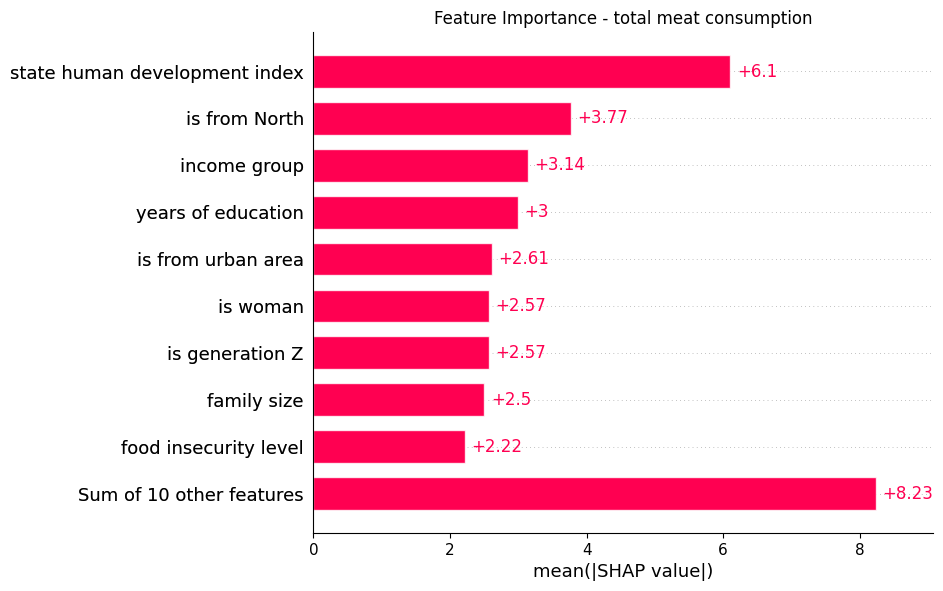

In [52]:
label = "total meat consumption"

X = df[features].copy()
y = df[label].copy()
X_tfm = X.copy().astype(float).values

X_tfm = pd.DataFrame(X_tfm, columns=X.columns)
model = XGBRegressor(random_state=314, n_jobs=-1, verbosity=0)
model.fit(X_tfm, y)

explainer = shap.explainers.Tree(model, X_tfm)
shap_values = explainer(X_tfm)

shap.plots.bar(shap_values, show=False)
plt.title(f"Feature Importance - {label}")
plt.savefig(f"output/shap_bar_{label}.png", bbox_inches="tight", dpi=300)
plt.show()

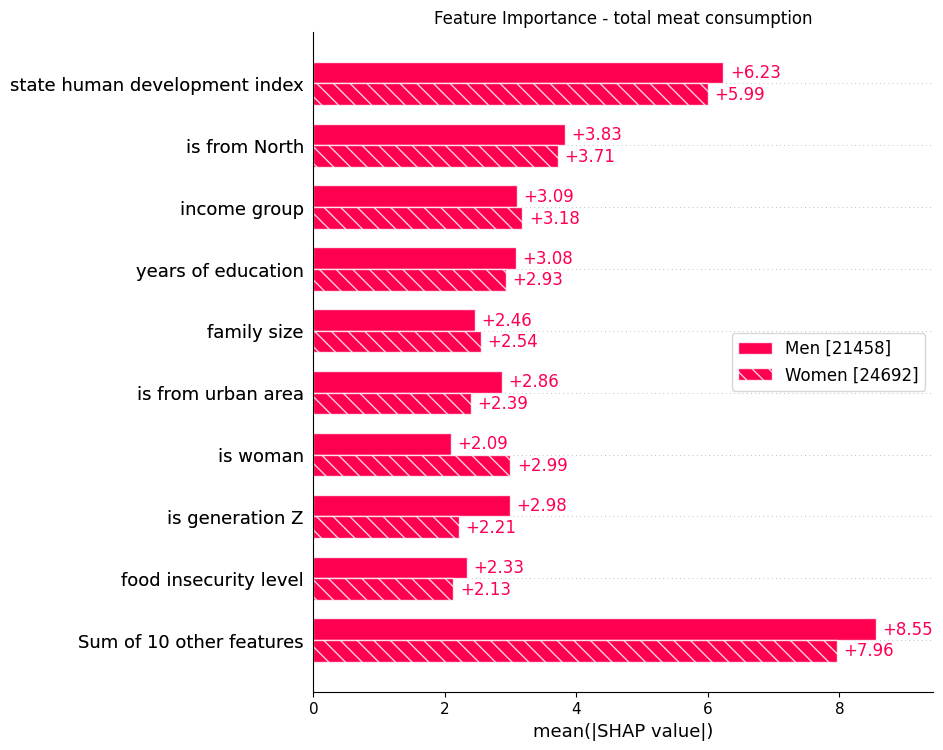

In [53]:
sex = [
    "Women" if shap_values[i, "is woman"].data == 1 else "Men"
    for i in range(shap_values.shape[0])
]
shap.plots.bar(shap_values.cohorts(sex).abs.mean(0), show=False)
plt.title(f"Feature Importance - {label}")
plt.savefig(f"output/shap_bar_cohorts_sex_{label}.png", bbox_inches="tight", dpi=300)
plt.show()

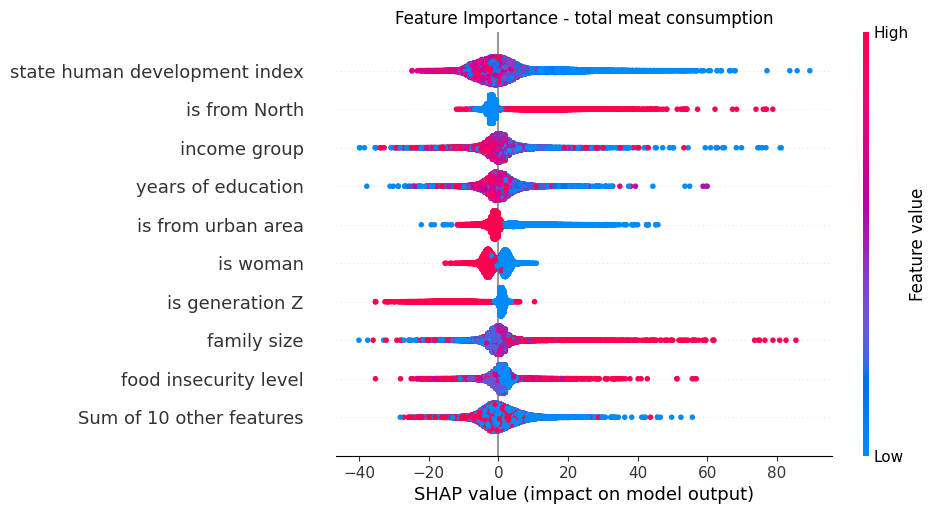

In [54]:
shap.plots.beeswarm(shap_values, show=False)
plt.title(f"Feature Importance - {label}")
plt.savefig(f"output/shap_beeswarm_{label}.png", bbox_inches="tight", dpi=300)
plt.show()

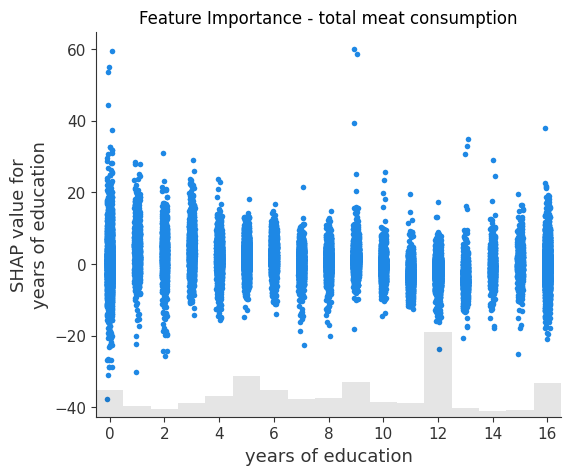

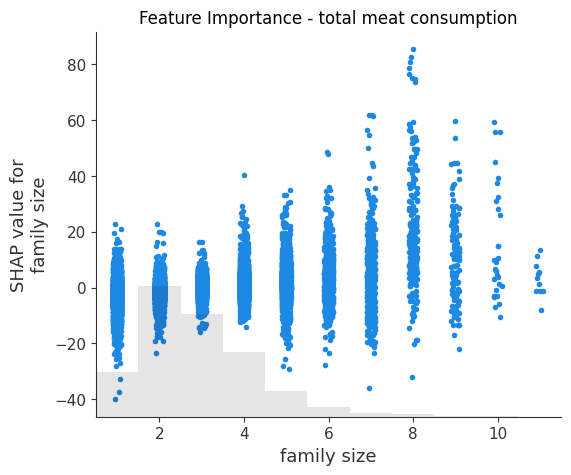

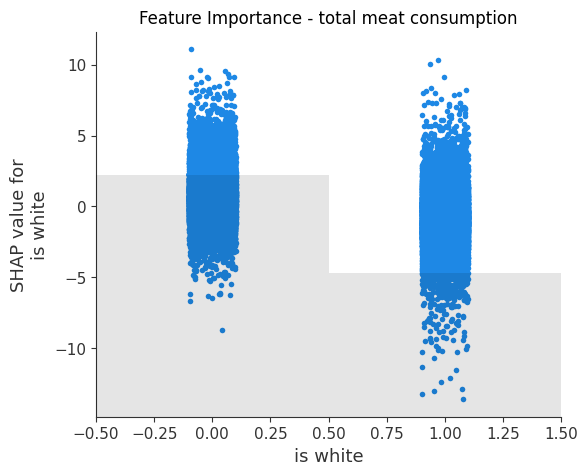

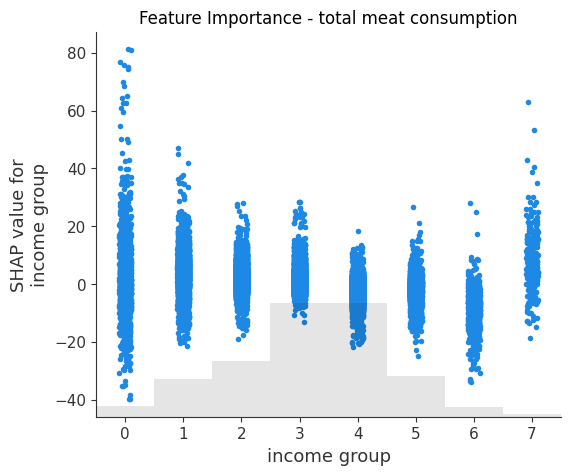

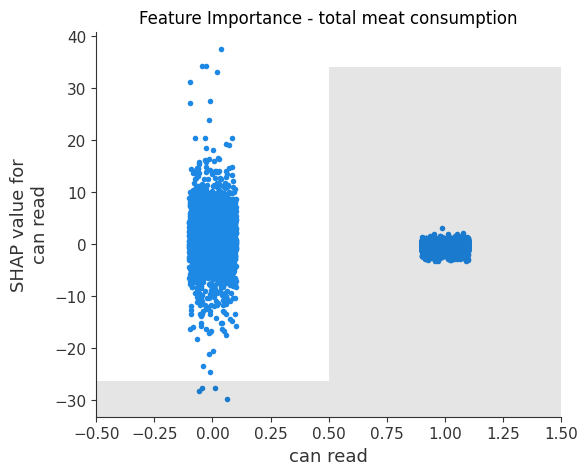

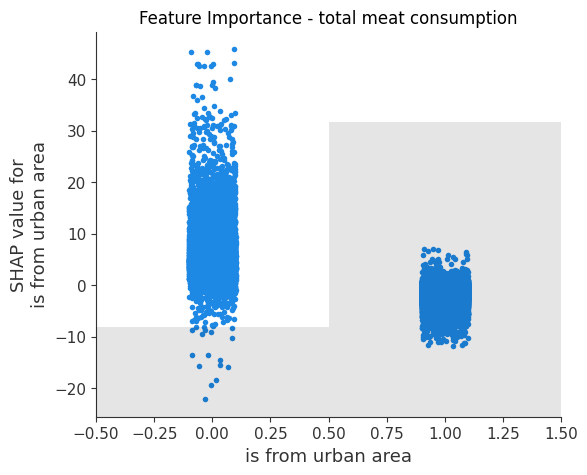

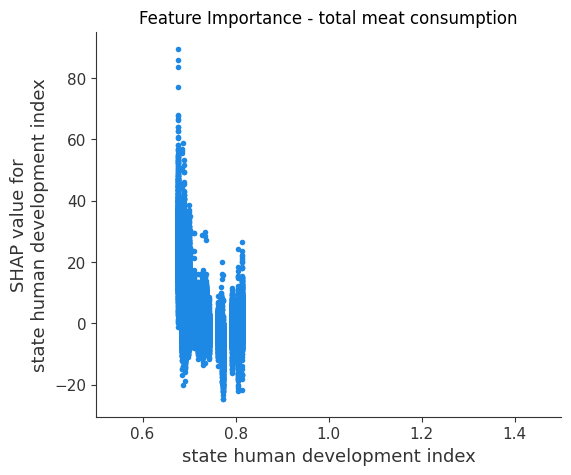

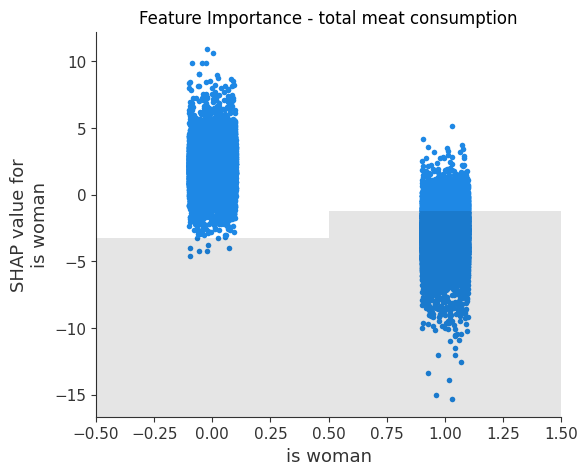

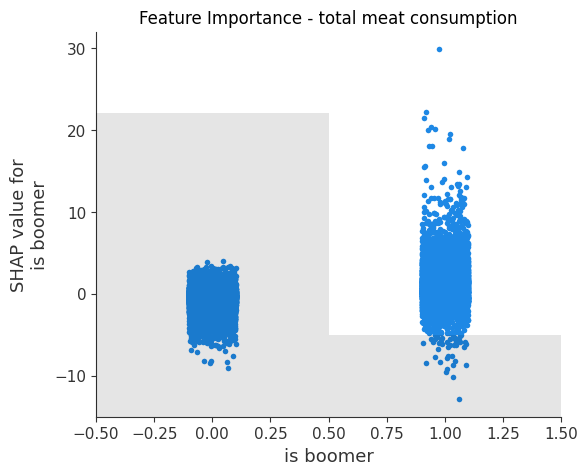

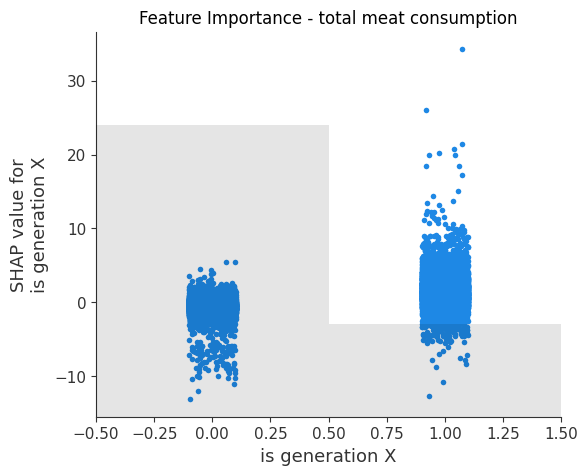

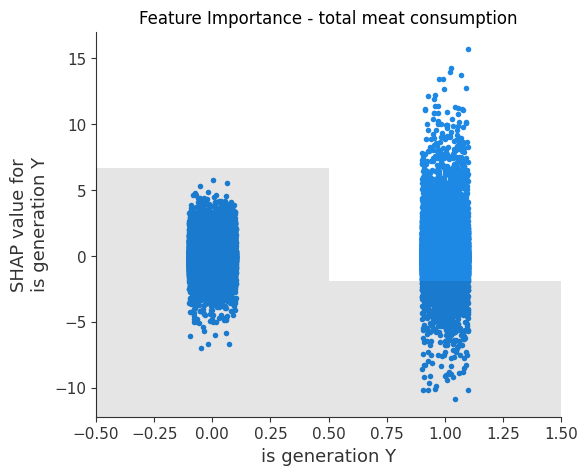

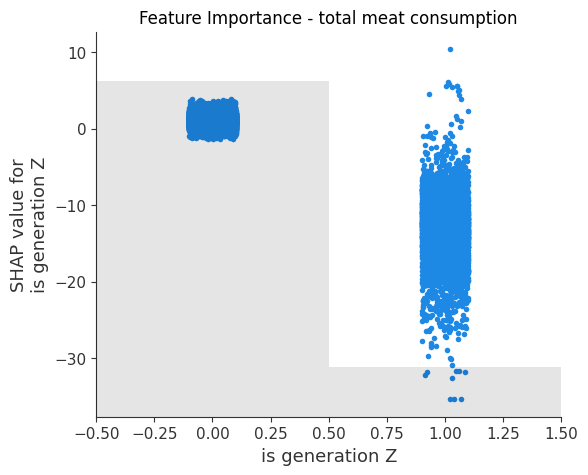

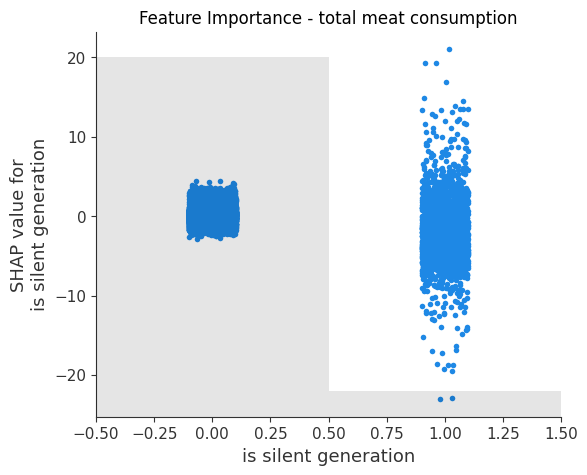

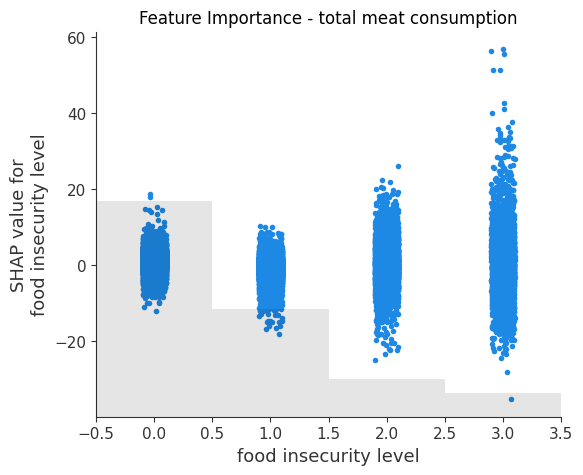

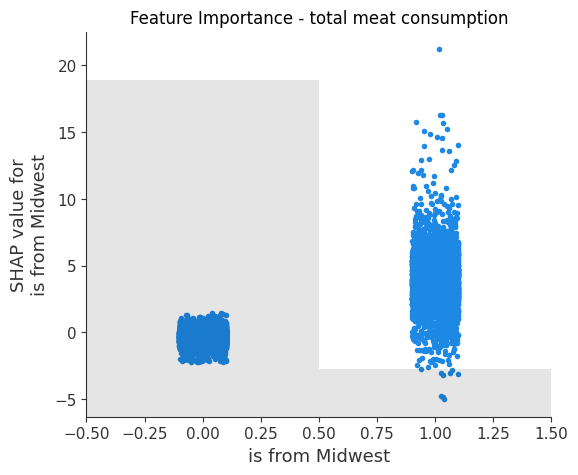

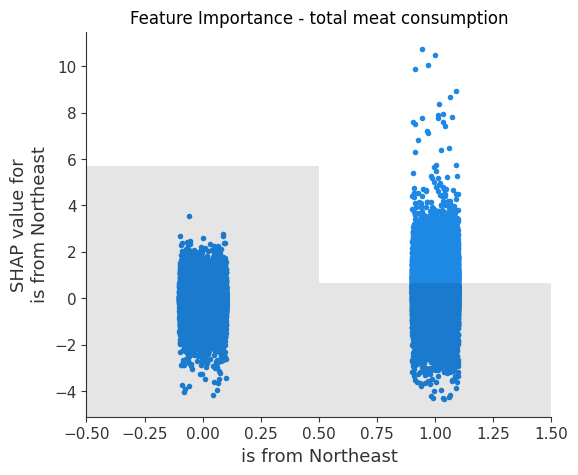

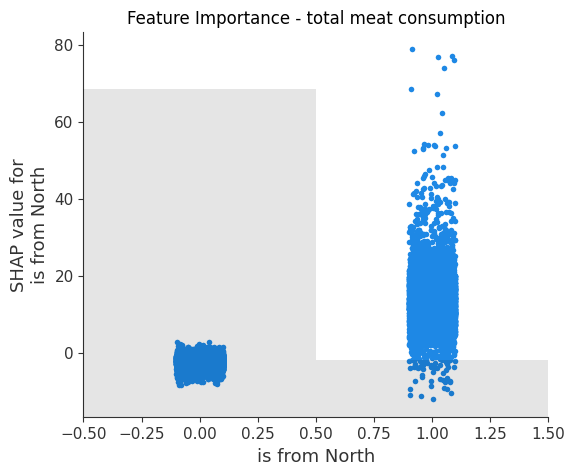

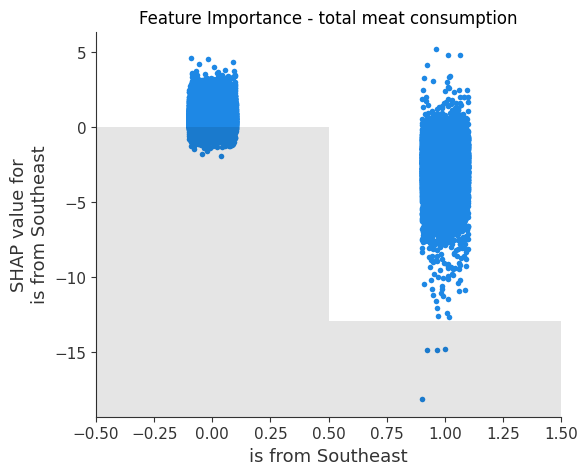

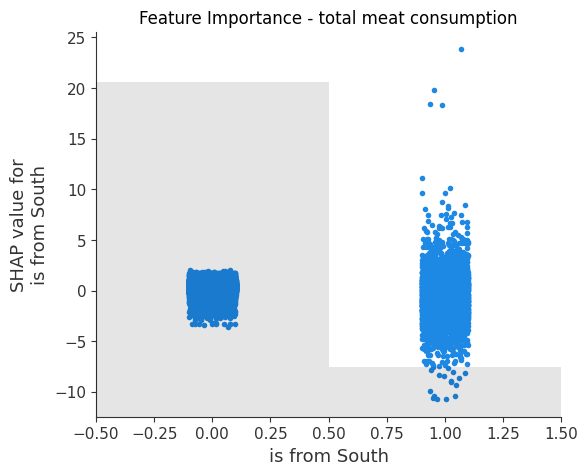

In [55]:
for col in X.columns:
    shap.plots.scatter(shap_values[:, col], show=False)
    plt.title(f"Feature Importance - {label}")
    plt.savefig(f"output/shap_scatter_{col}_{label}.png", bbox_inches="tight", dpi=300)
    plt.show()

# SHAP - Red meat consumption

 21%|====                | 9806/46150 [00:36<02:13]       

100%|===================| 46123/46150 [02:40<00:00]        

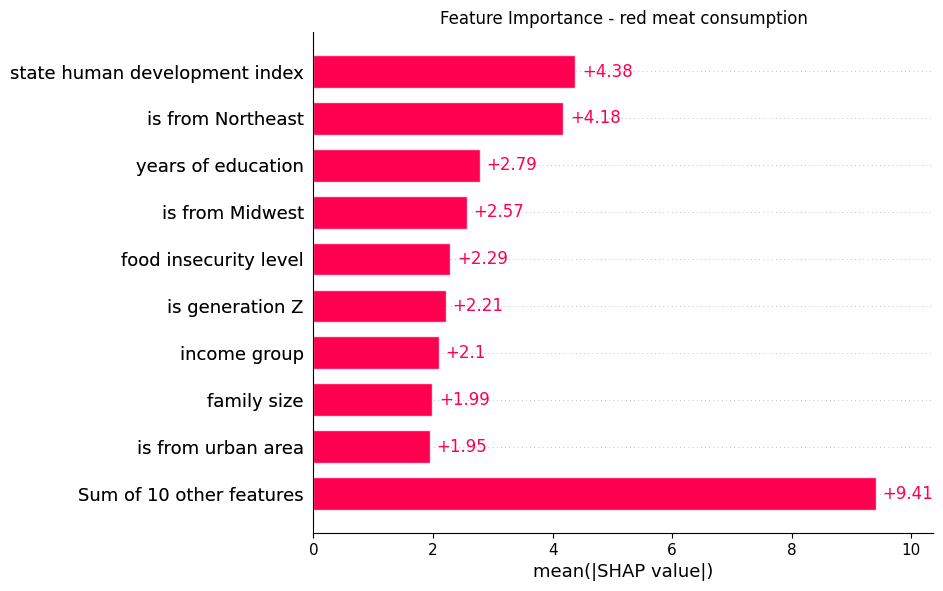

In [56]:
label = "red meat consumption"

X = df[features].copy()
y = df[label].copy()
X_tfm = X.copy().astype(float).values

X_tfm = pd.DataFrame(X_tfm, columns=X.columns)
model = XGBRegressor(random_state=314, n_jobs=-1, verbosity=0)
model.fit(X_tfm, y)

explainer = shap.explainers.Tree(model, X_tfm)
shap_values = explainer(X_tfm)

shap.plots.bar(shap_values, show=False)
plt.title(f"Feature Importance - {label}")
plt.savefig(f"output/shap_bar_{label}.png", bbox_inches="tight", dpi=300)
plt.show()

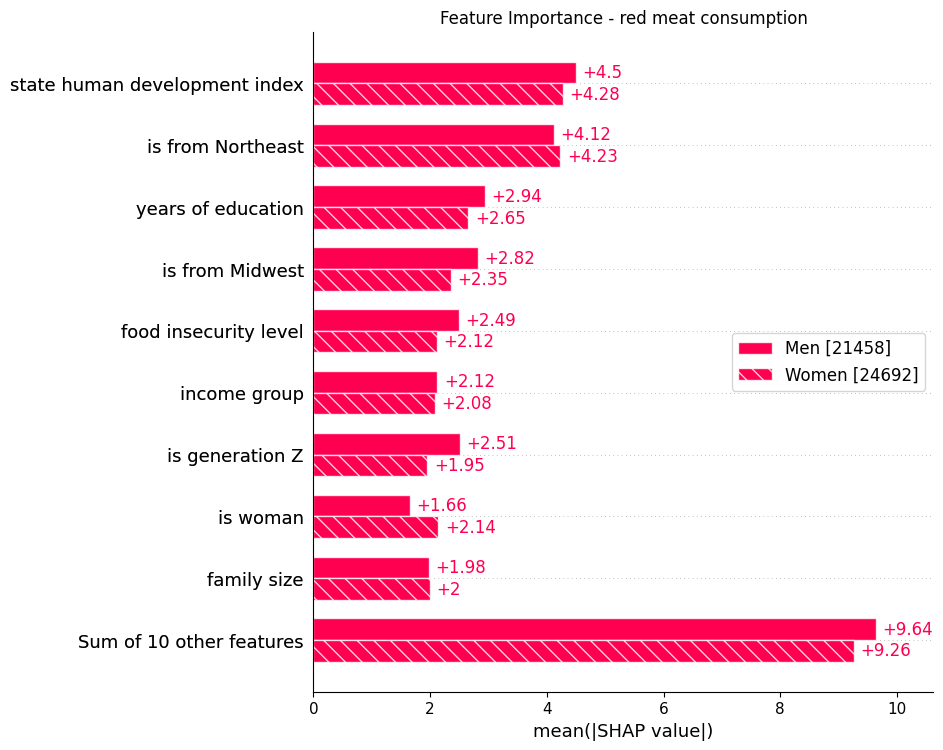

In [57]:
sex = [
    "Women" if shap_values[i, "is woman"].data == 1 else "Men"
    for i in range(shap_values.shape[0])
]
shap.plots.bar(shap_values.cohorts(sex).abs.mean(0), show=False)
plt.title(f"Feature Importance - {label}")
plt.savefig(f"output/shap_bar_cohorts_sex_{label}.png", bbox_inches="tight", dpi=300)
plt.show()

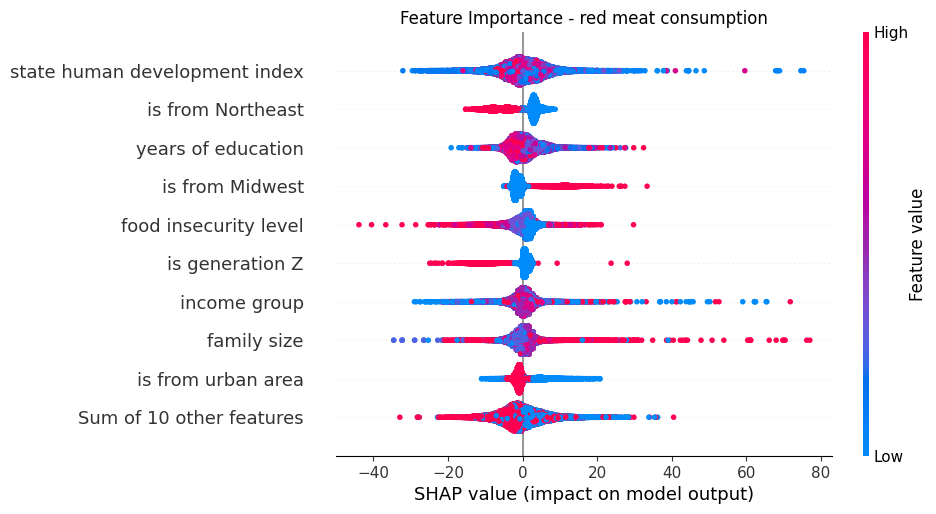

In [58]:
shap.plots.beeswarm(shap_values, show=False)
plt.title(f"Feature Importance - {label}")
plt.savefig(f"output/shap_beeswarm_{label}.png", bbox_inches="tight", dpi=300)
plt.show()

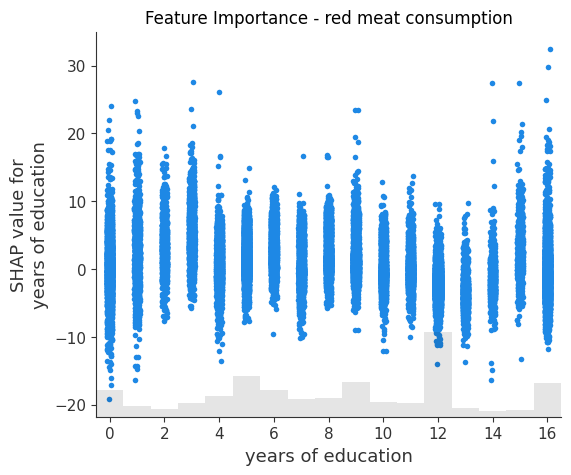

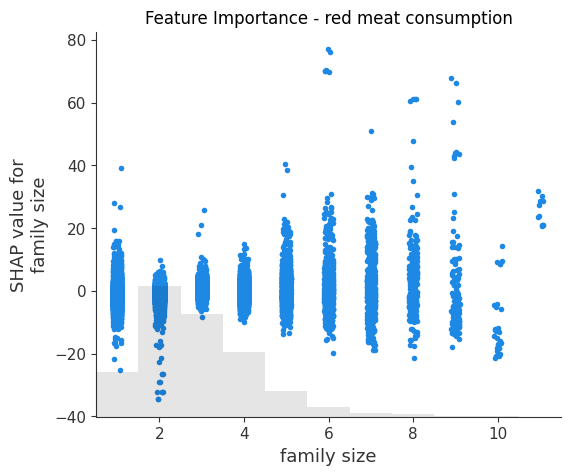

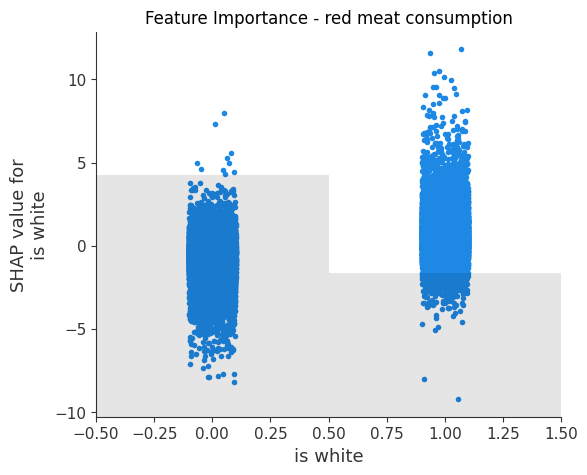

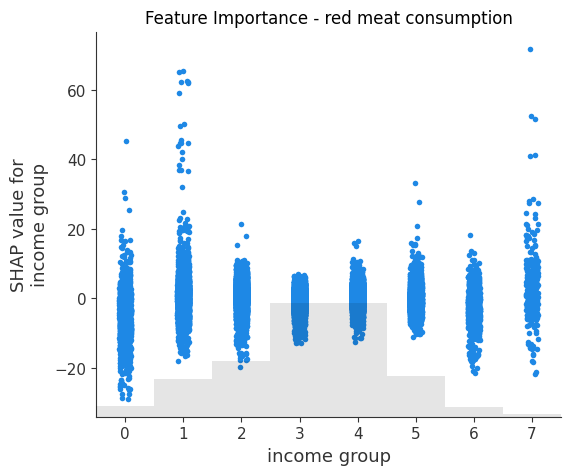

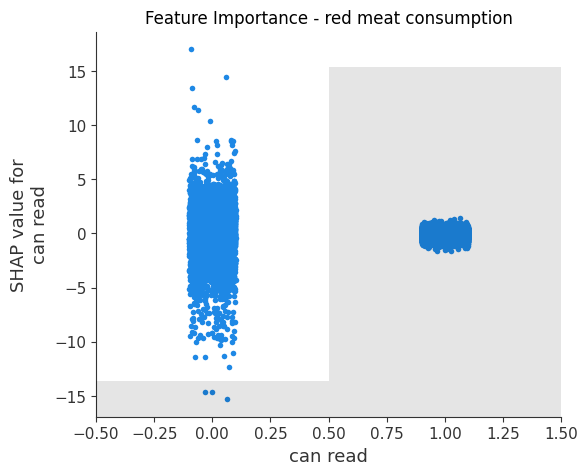

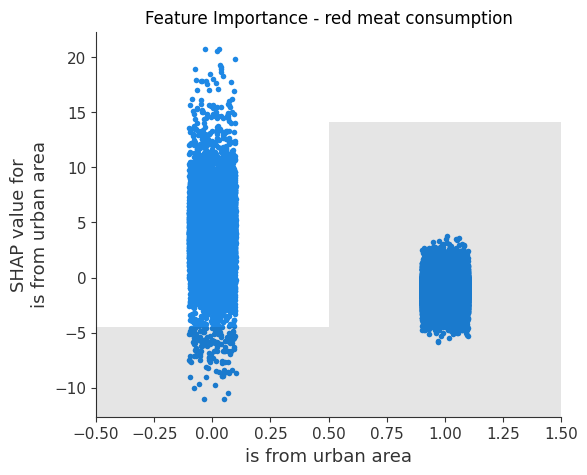

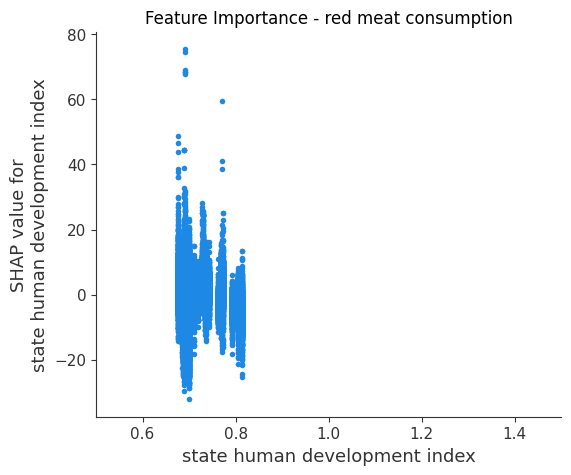

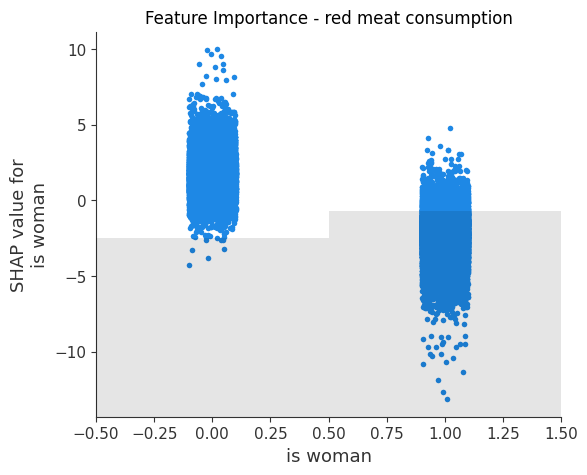

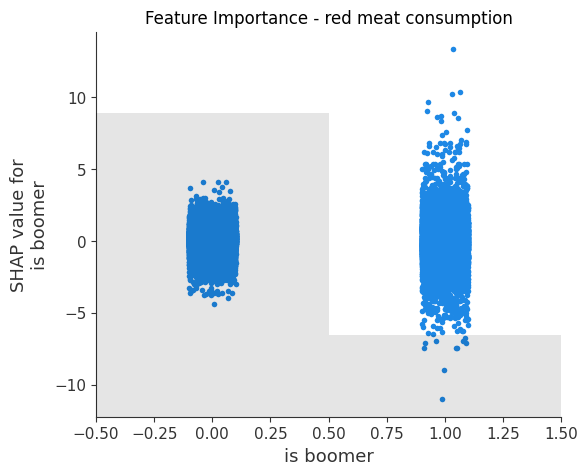

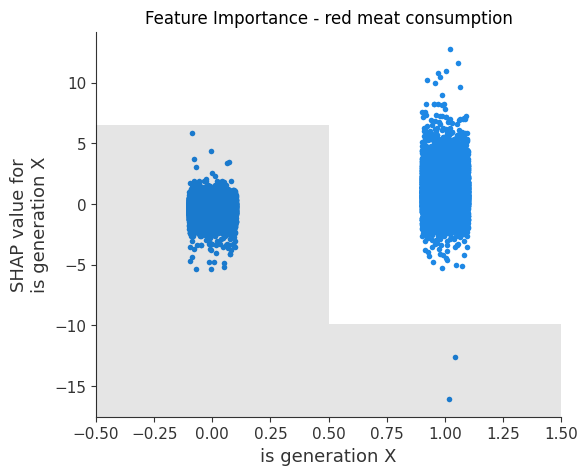

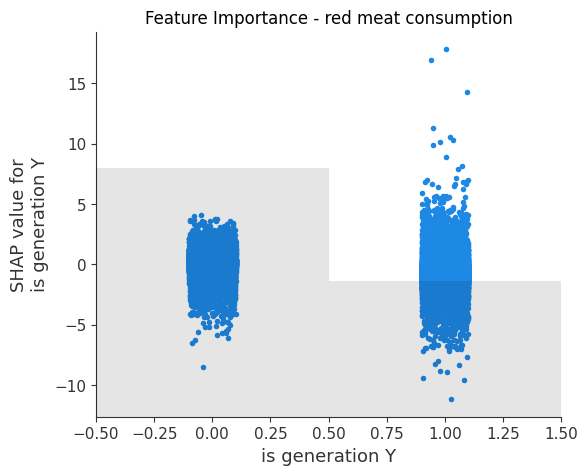

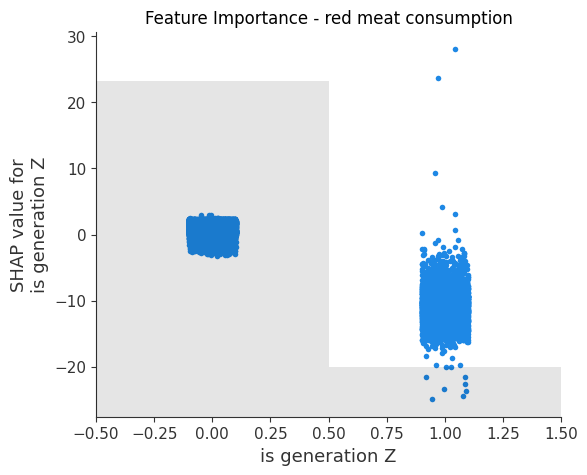

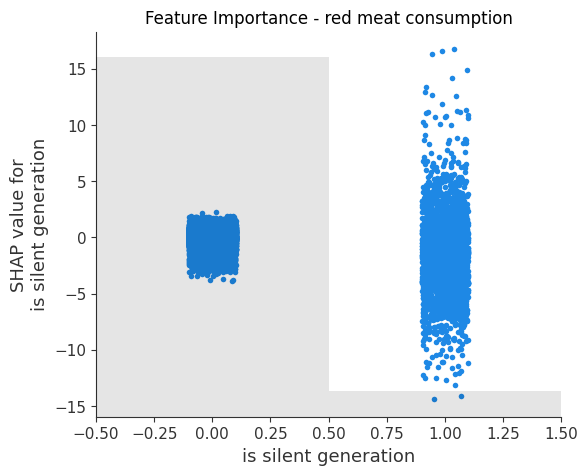

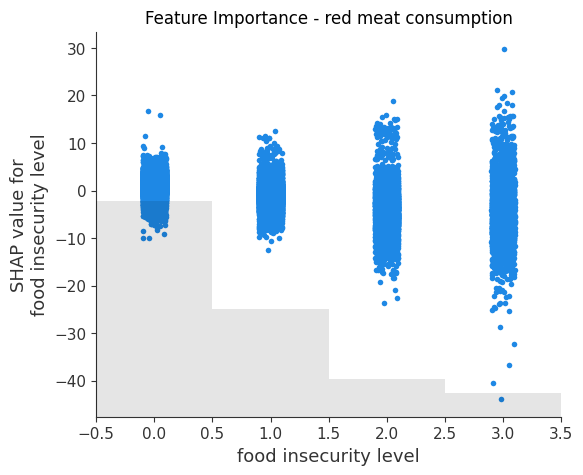

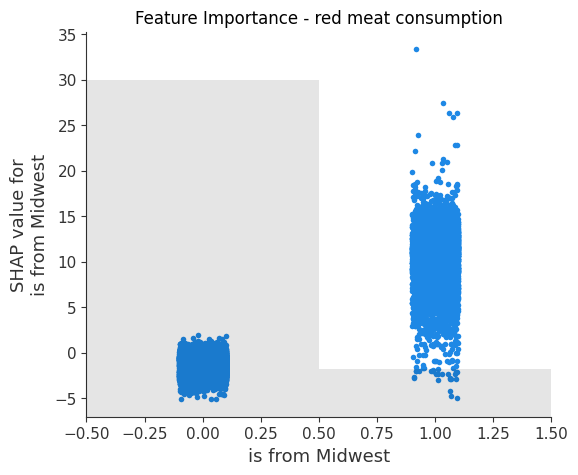

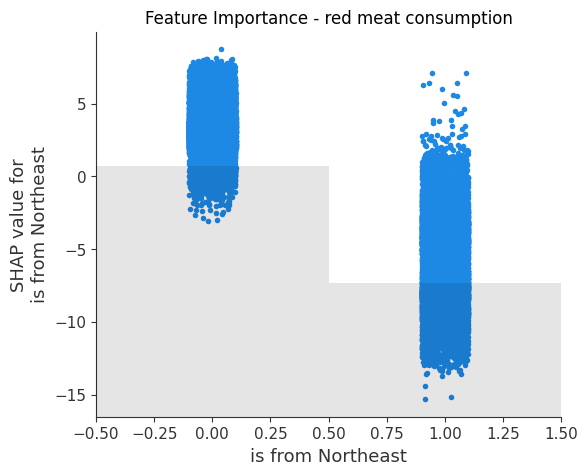

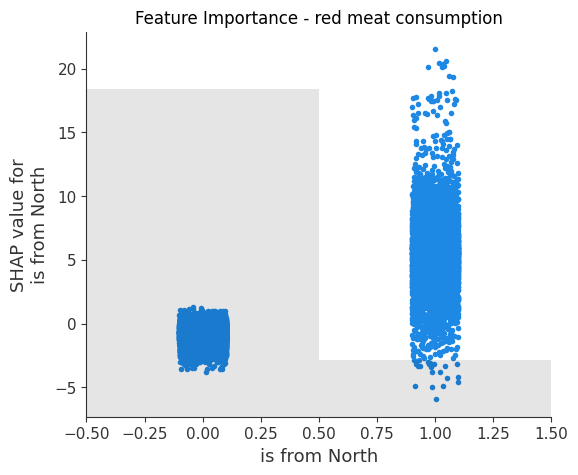

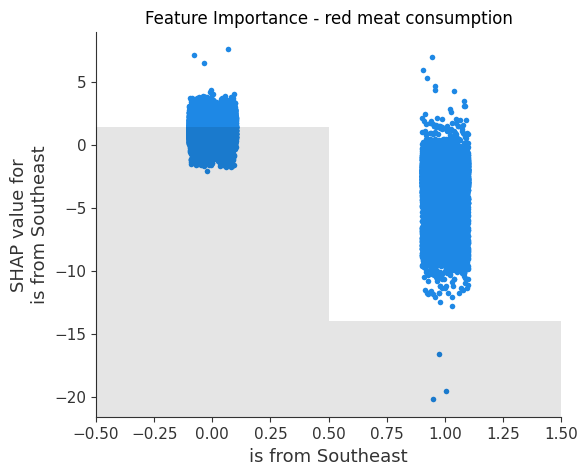

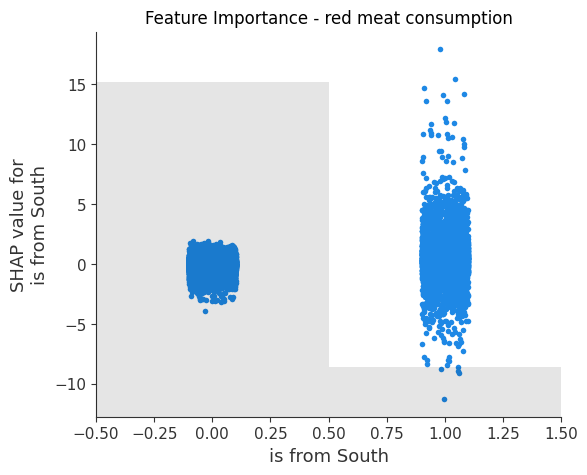

In [59]:
for col in X.columns:
    shap.plots.scatter(shap_values[:, col], show=False)
    plt.title(f"Feature Importance - {label}")
    plt.savefig(f"output/shap_scatter_{col}_{label}.png", bbox_inches="tight", dpi=300)
    plt.show()

# SHAP - White meat consumption

100%|===================| 45955/46150 [02:39<00:00]        

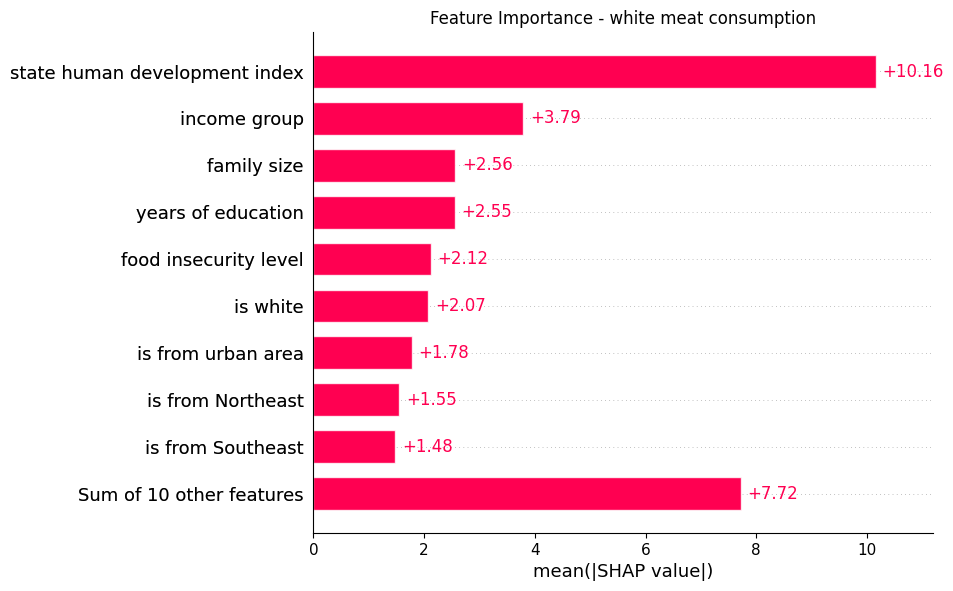

In [60]:
label = "white meat consumption"

X = df[features].copy()
y = df[label].copy()
X_tfm = X.copy().astype(float).values

X_tfm = pd.DataFrame(X_tfm, columns=X.columns)
model = XGBRegressor(random_state=314, n_jobs=-1, verbosity=0)
model.fit(X_tfm, y)

explainer = shap.explainers.Tree(model, X_tfm)
shap_values = explainer(X_tfm)

shap.plots.bar(shap_values, show=False)
plt.title(f"Feature Importance - {label}")
plt.savefig(f"output/shap_bar_{label}.png", bbox_inches="tight", dpi=300)
plt.show()

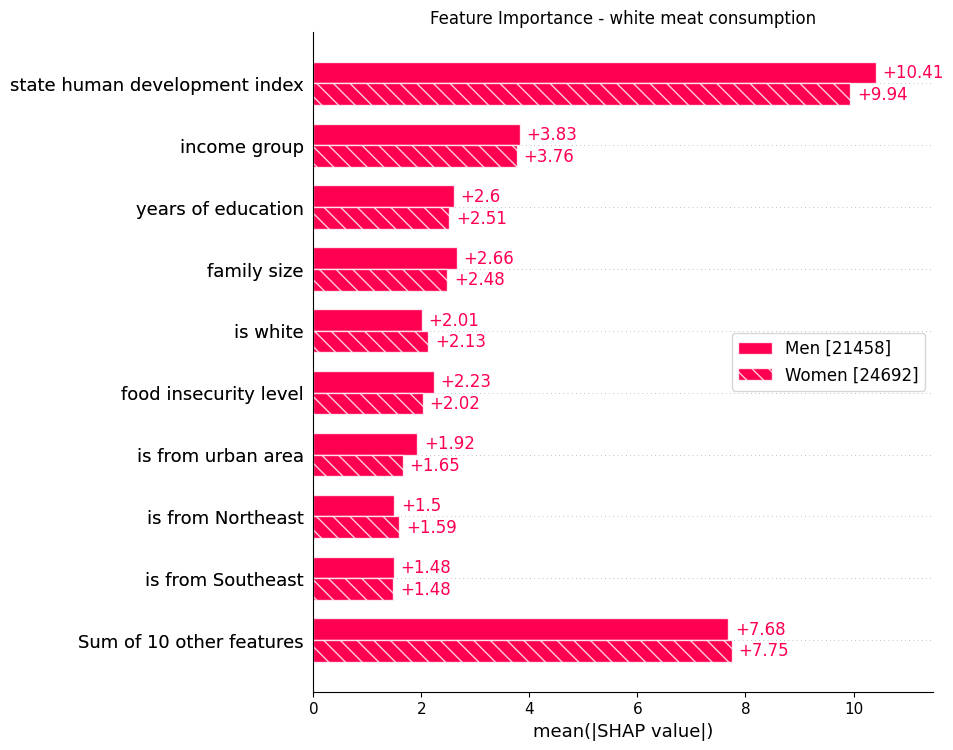

In [61]:
sex = [
    "Women" if shap_values[i, "is woman"].data == 1 else "Men"
    for i in range(shap_values.shape[0])
]
shap.plots.bar(shap_values.cohorts(sex).abs.mean(0), show=False)
plt.title(f"Feature Importance - {label}")
plt.savefig(f"output/shap_bar_cohorts_sex_{label}.png", bbox_inches="tight", dpi=300)
plt.show()

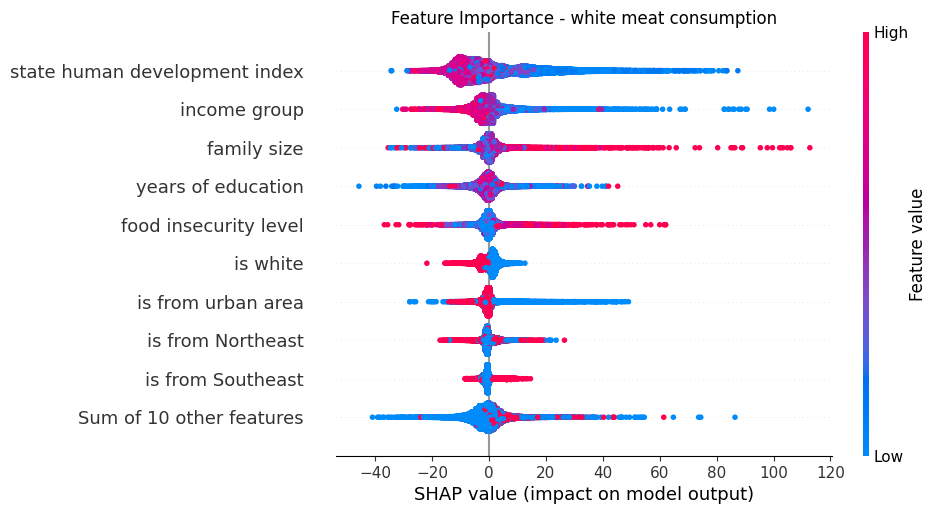

In [62]:
shap.plots.beeswarm(shap_values, show=False)
plt.title(f"Feature Importance - {label}")
plt.savefig(f"output/shap_beeswarm_{label}.png", bbox_inches="tight", dpi=300)
plt.show()

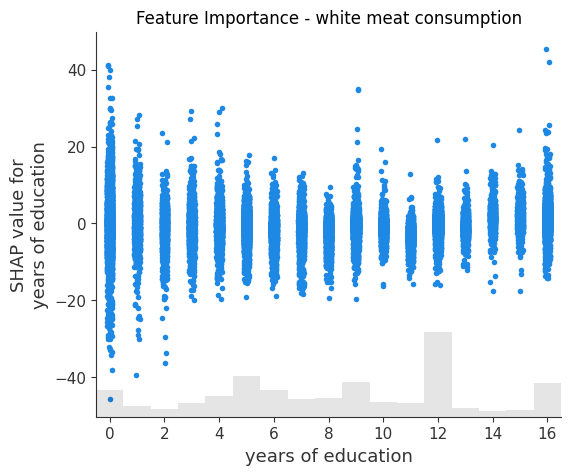

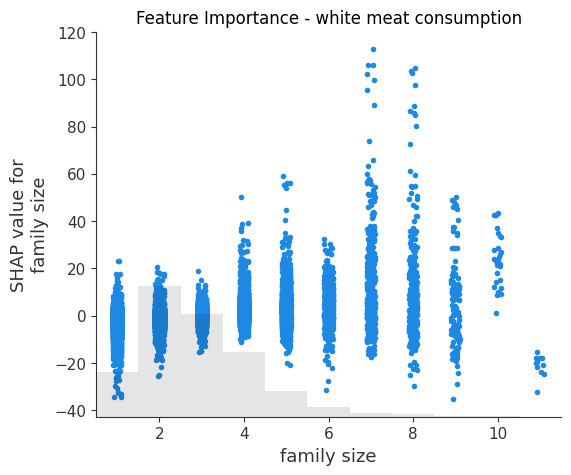

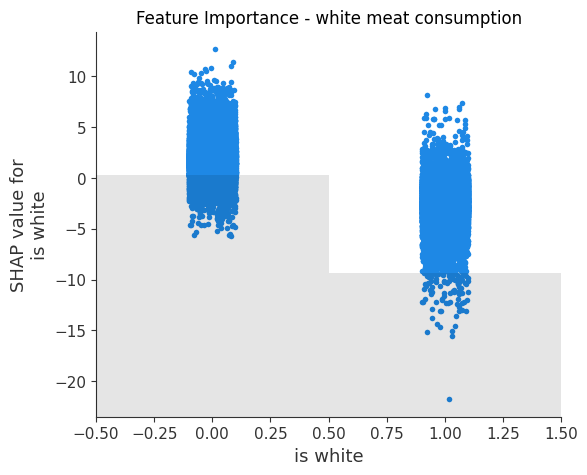

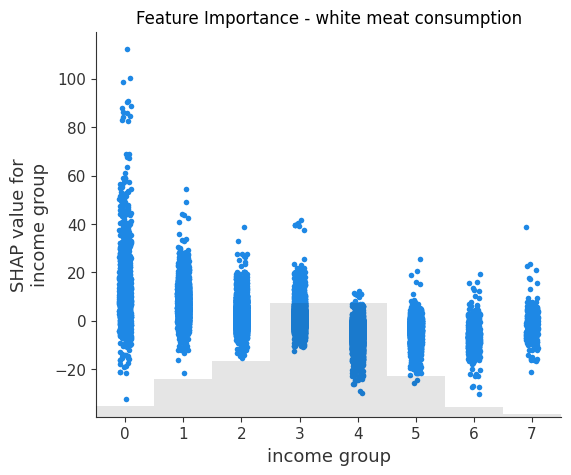

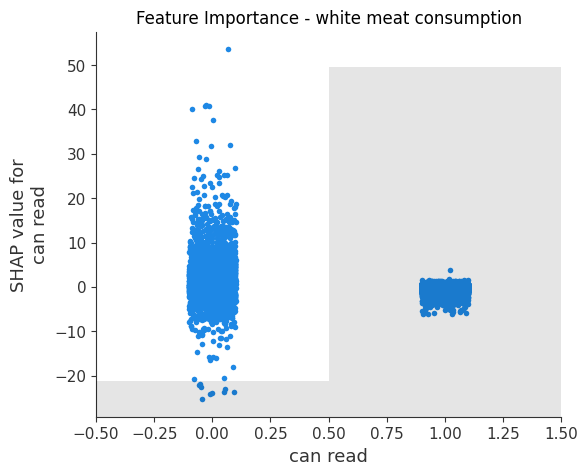

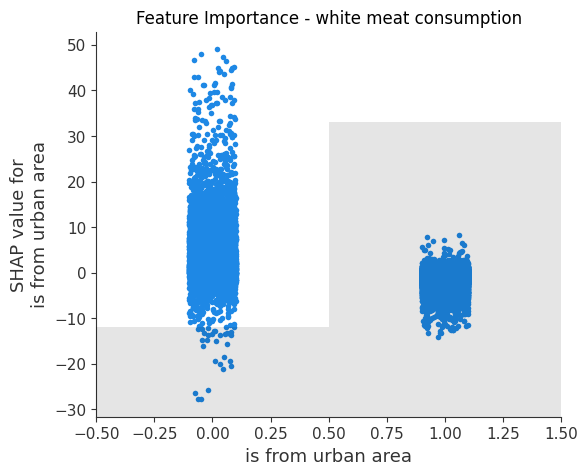

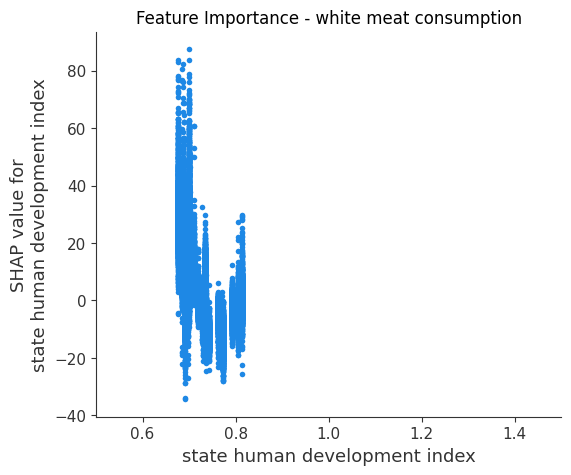

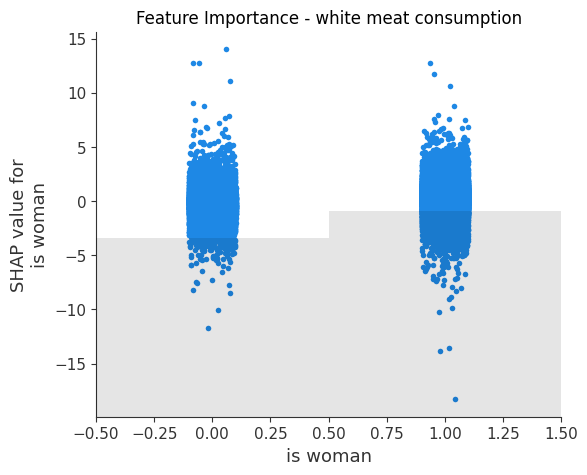

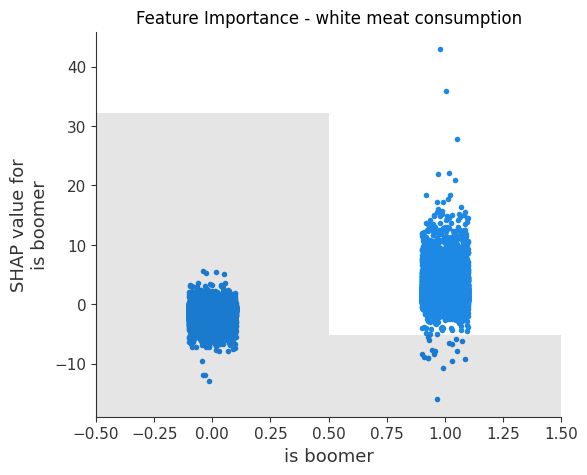

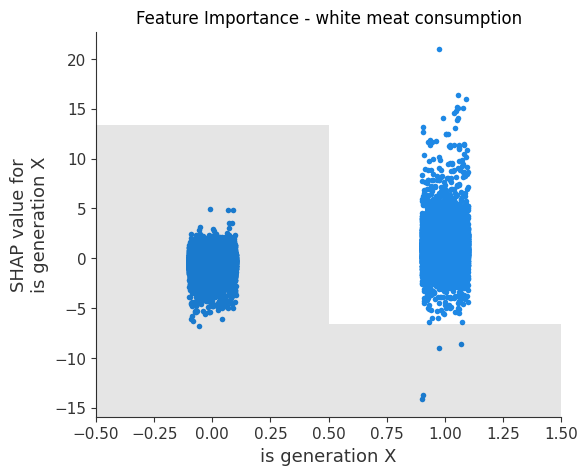

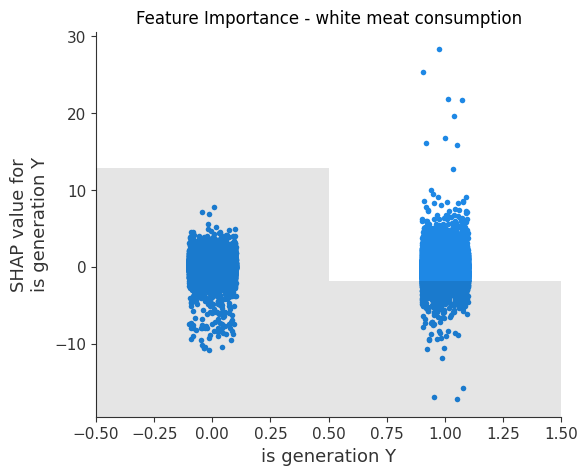

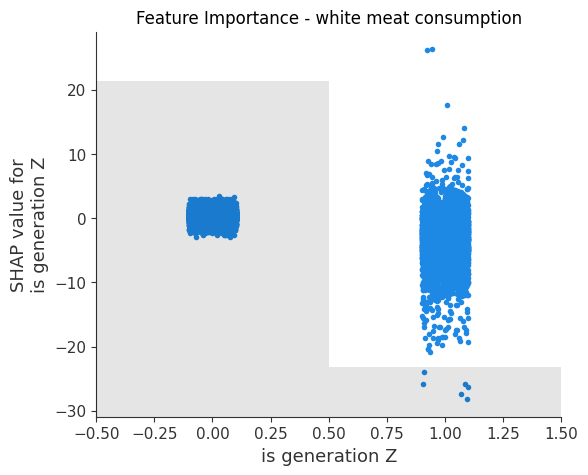

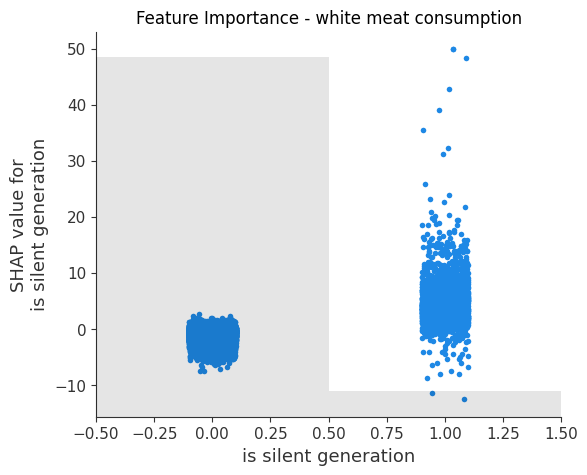

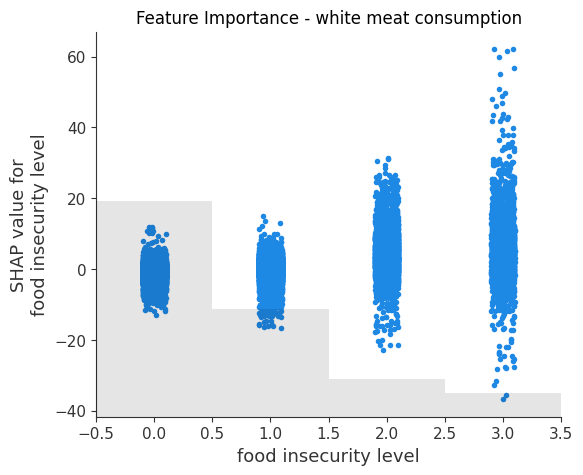

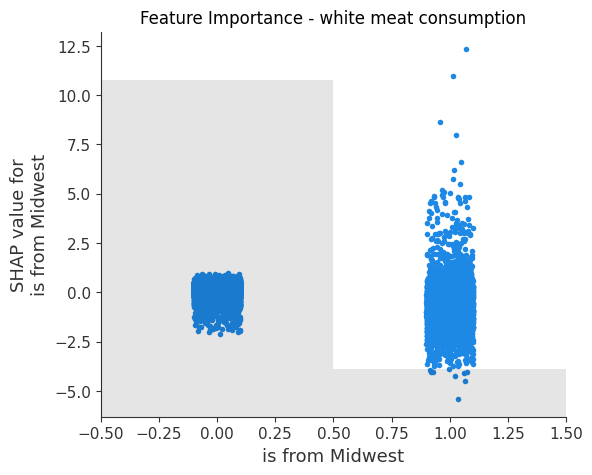

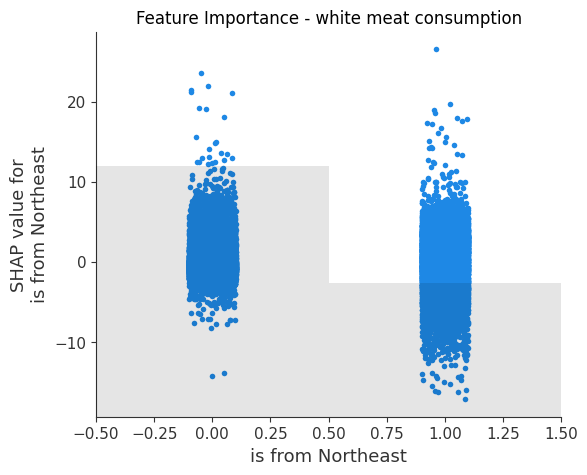

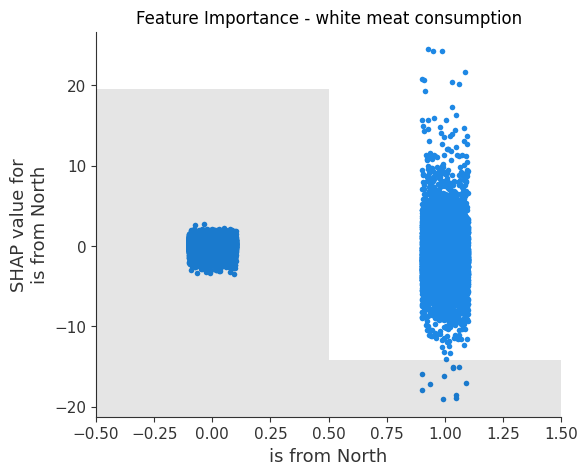

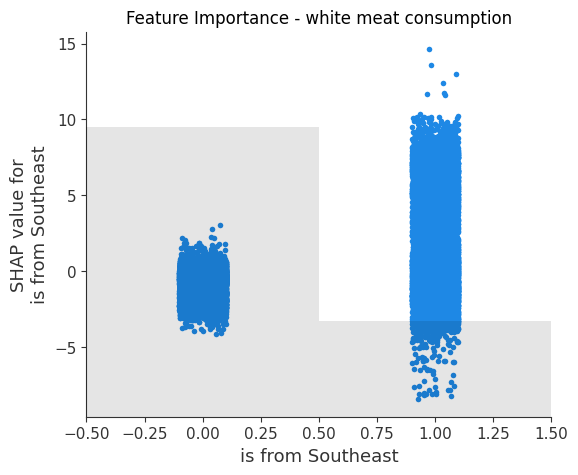

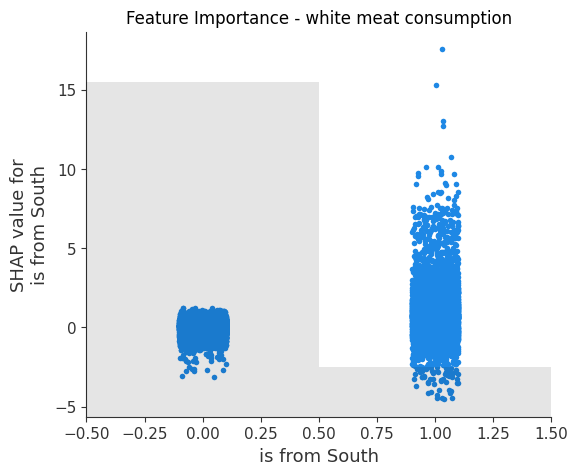

In [63]:
for col in X.columns:
    shap.plots.scatter(shap_values[:, col], show=False)
    plt.title(f"Feature Importance - {label}")
    plt.savefig(f"output/shap_scatter_{col}_{label}.png", bbox_inches="tight", dpi=300)
    plt.show()